In [2]:
## librerias de transformación de datos 
library(dplyr)
library(tidyverse)
library(scales)
library(purrr)

## librerias para Machine Learning 
library(cluster)
library(dbscan)
library(fpc)
library(mclust)

## librerias para validación de Clusteres
library(clValid)
library(NbClust)

#librerias para visualización de datos 
library(ggplot2)
library(factoextra)
library (corrplot)
library(psych)


# Comprensión de los datos

In [3]:
data <- read.csv("C:\\Users\\dcruz\\Documents\\Master en Intelegencia Artificial\\TFM\\Practica\\Datasets\\Consumos Porcentajes VMware.csv", encoding = "latin-1", sep = ";", dec = ",")

In [4]:
head(data)

VMName,RAM,RAM_percentage,RAM_LastAvgUse_Gb_SD,CPUCount,CPU_percentage,CPU_LastAvgUse_MHz_SD,NETWORK_LastInboundAvgUse_Kbps_P95,NETWORK_LastInboundAvgUse_Kbps_SD,NETWORK_LastOutboundAvgUse_Kbps_P95,NETWORK_LastOutboundAvgUse_Kbps_SD
1000095_WINDOWS_SERVER_2012_R2_DATACENTER_64Bits,4,100,1,2,9,331,90,38,62,78
100634_FUNDACION_CIDCA_WIN_2003_32BIT_NEW (8f6e8a9c-c313-4a0a-9ba7-6573eae022d8),24,100,0,12,1,158,0,0,0,1
1006695_WINDOWS_SERVER_2016_DATACENTER_64 (55f438ca-6813-43df-83fa-892ea2c0b78d),4,100,0,2,21,337,0,19,0,1
100854_SERFIN_Contardocloud (07200194-5a6a-4629-9242-d17b265099e0),8,100,0,8,10,585,5,7,7,13
100854_SERFIN_Contardocloud_0501,8,100,0,8,71,5810,34,13,20,9
107479_DEBIAN_6.0.8_64Bits (6af5ec21-3624-4336-a70f-e358e41b1e79),2,100,0,2,0,49,1,784,0,4


# Preparación de los datos 

In [5]:
data  <- data[data$RAM<=128,]
data  <- data[data$CPUCount<=64,]

features <- c("RAM","RAM_percentage","CPUCount","CPU_percentage")


datos <- scale(data[,features])

In [6]:
dim(datos)

[1] 1877    4

In [7]:
head(datos, 10)

,RAM,RAM_percentage,CPUCount,CPU_percentage
1,-0.6299373,0.5132675,-0.6726152,-0.38603518
2,0.2290161,0.5132675,1.1113310,-0.68841934
3,-0.6299373,0.5132675,-0.6726152,0.06754105
4,-0.4581466,0.5132675,0.3977525,-0.34823716
5,-0.4581466,0.5132675,0.3977525,1.95744203
6,-0.7158326,0.5132675,-0.6726152,-0.72621736
7,-0.6299373,0.4304867,-0.3158260,-0.27264112
8,0.2290161,-1.5148624,0.3977525,-0.42383320
9,-0.4581466,0.5132675,-0.3158260,-0.49942924
10,-0.4581466,0.5132675,-0.3158260,-0.42383320


## Reducción de dimensionalidad

### Analisis principal de componentes

In [8]:
head(data[features])

RAM,RAM_percentage,CPUCount,CPU_percentage
4,100,2,9
24,100,12,1
4,100,2,21
8,100,8,10
8,100,8,71
2,100,2,0


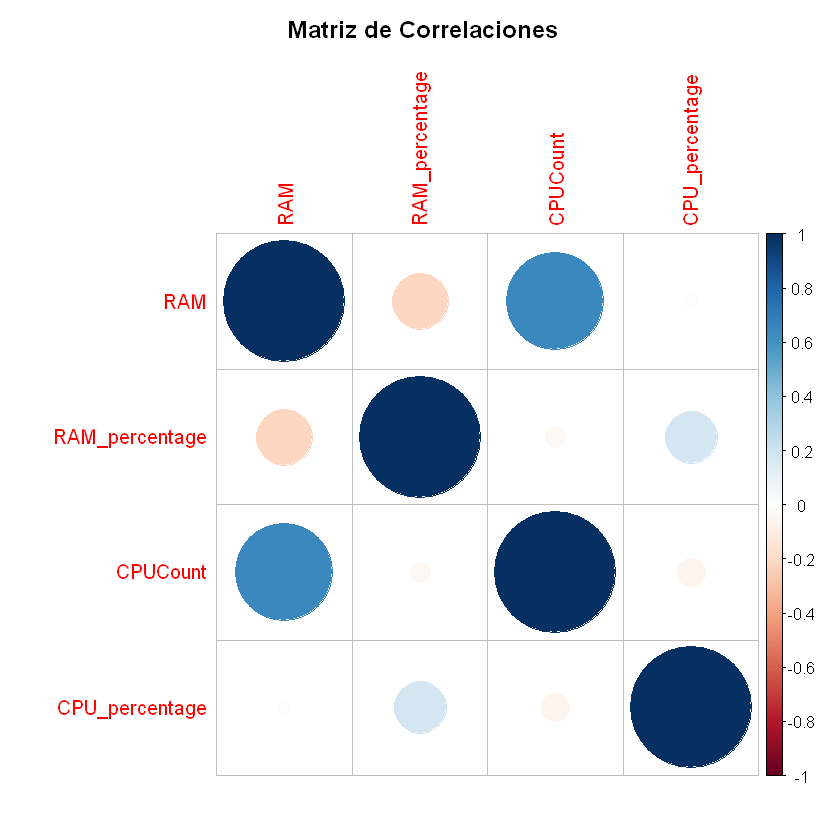

In [9]:
corr <- cor(datos)
corrplot(corr, method= "circle", title="\n\n Matriz de Correlaciones")

In [10]:
datos_acp <- prcomp(datos, scale = T)
a<-summary(datos_acp)

a

Importance of components%s:
                          PC1    PC2    PC3     PC4
Standard deviation     1.3050 1.0726 0.9130 0.55945
Proportion of Variance 0.4257 0.2876 0.2084 0.07825
Cumulative Proportion  0.4257 0.7134 0.9217 1.00000

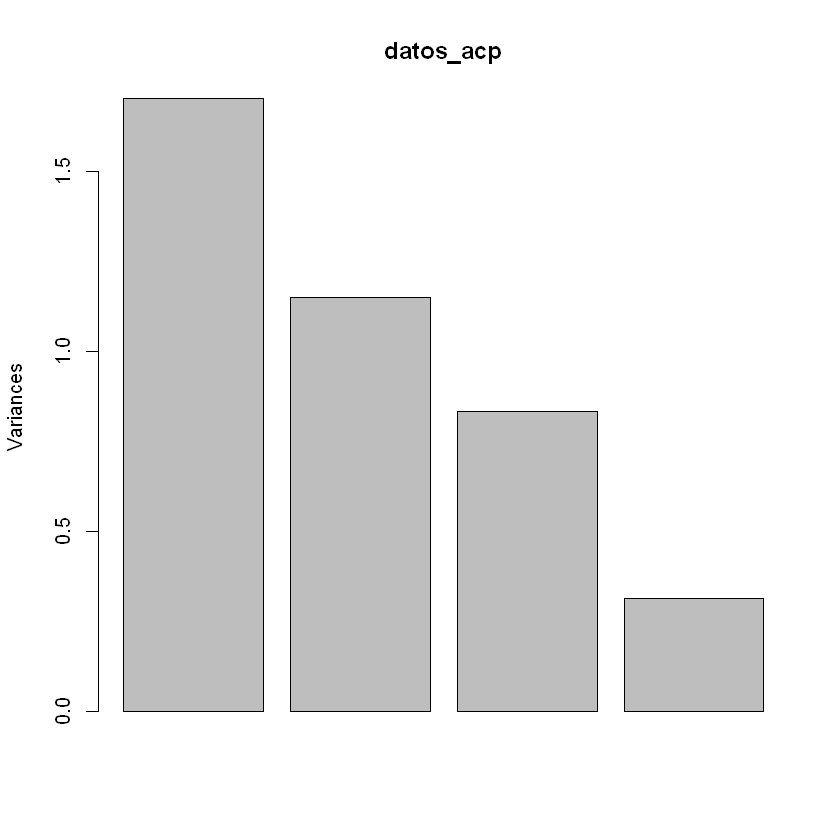

In [11]:
plot(datos_acp, )

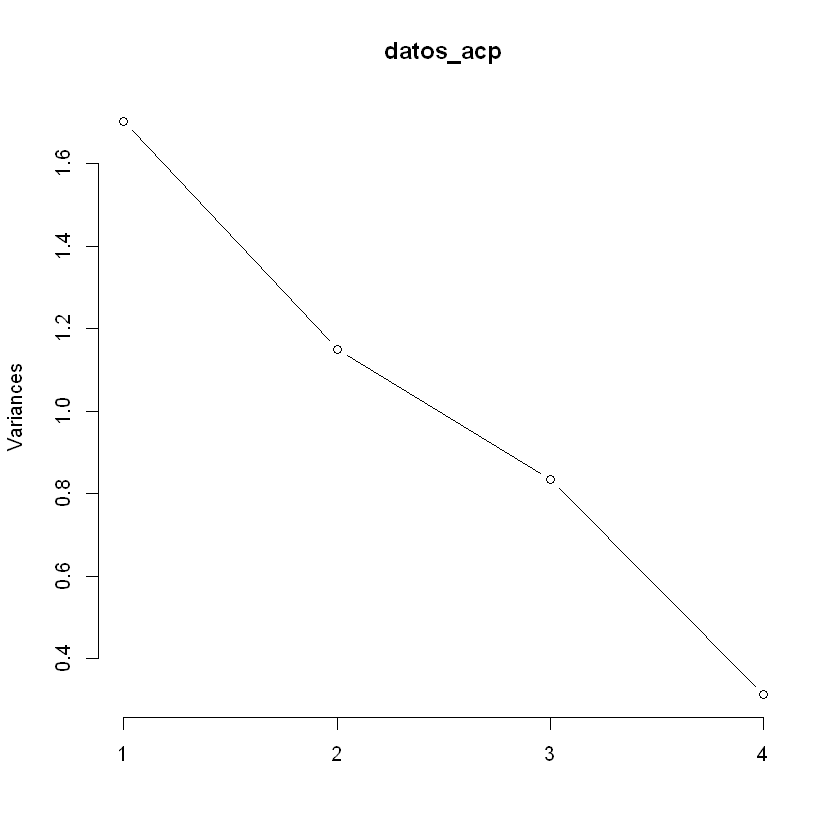

In [12]:
plot(datos_acp, type = "lines")

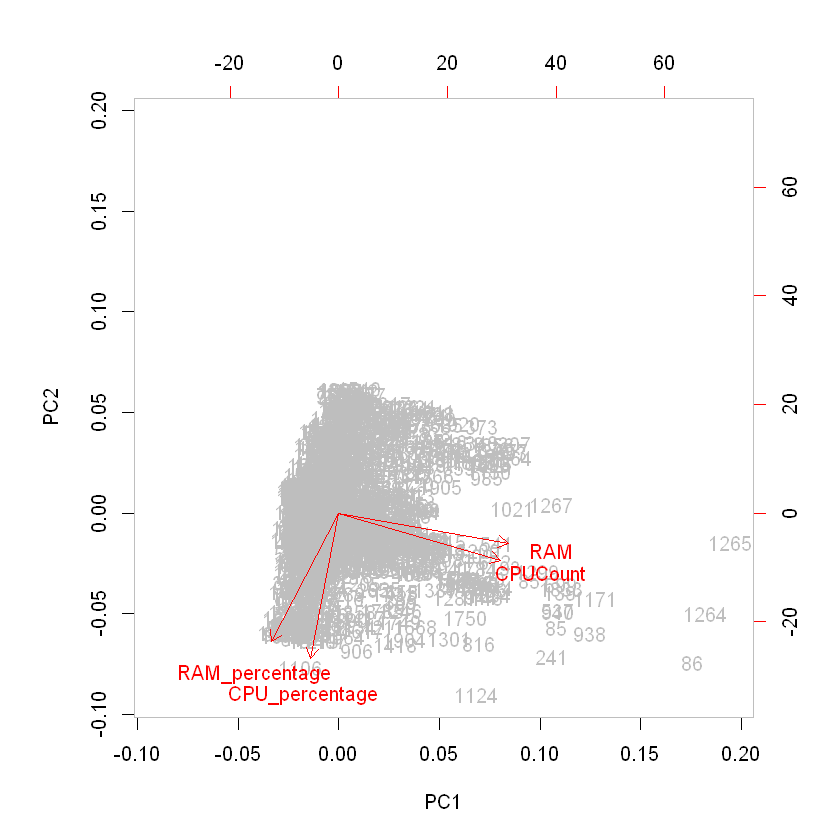

In [13]:
biplot(datos_acp, col = c("gray", "red"))

## Estudio de la tendencia de clustering

Antes de aplicar un método de clustering a los datos es conveniente evaluar si hay indicios de que realmente existe algún tipo de agrupación en ellos. A este proceso se le conoce como assessing cluster tendecy y puede llevarse a cabo mediante test estadísticos (Hopkins statistic) o de forma visual (Visual Assessment of cluster Tendency).

### Hopkins statistics

El estadístico Hopkins permite evaluar la tendencia de clustering de un conjunto de datos mediante el cálculo de la probabilidad de que dichos datos procedan de una distribución uniforme, es decir, estudia la distribución espacial aleatoria de las observaciones.

In [14]:
library(clustertend)
set.seed(321)

# Estadístico H para el set de datos 
hopkins(data = datos, n = nrow(datos) - 1)

$H
[1] 0.05416248

El estadistico de Hopkins tiene un valor aproximado a 0.05. Como este valor es muy cercano a 0, se puede interpretarm que los datos no responden a una ditribución uniforme y es posible aplicar tecnicas de clustering para encontrar agrupaciones naturales en los datos

### Visual Assessment of cluster Tendency (VAT)

VAT es método que permite evaluar visualmente si los datos muestran indicios de algún tipo de agrupación. Se representa gráficamente la matriz de distancias ordenada, empleando un gradiente de color para el valor de las distancias. Si existen agrupaciones subyacentes en los datos se forma un patrón de bloques cuadrados.

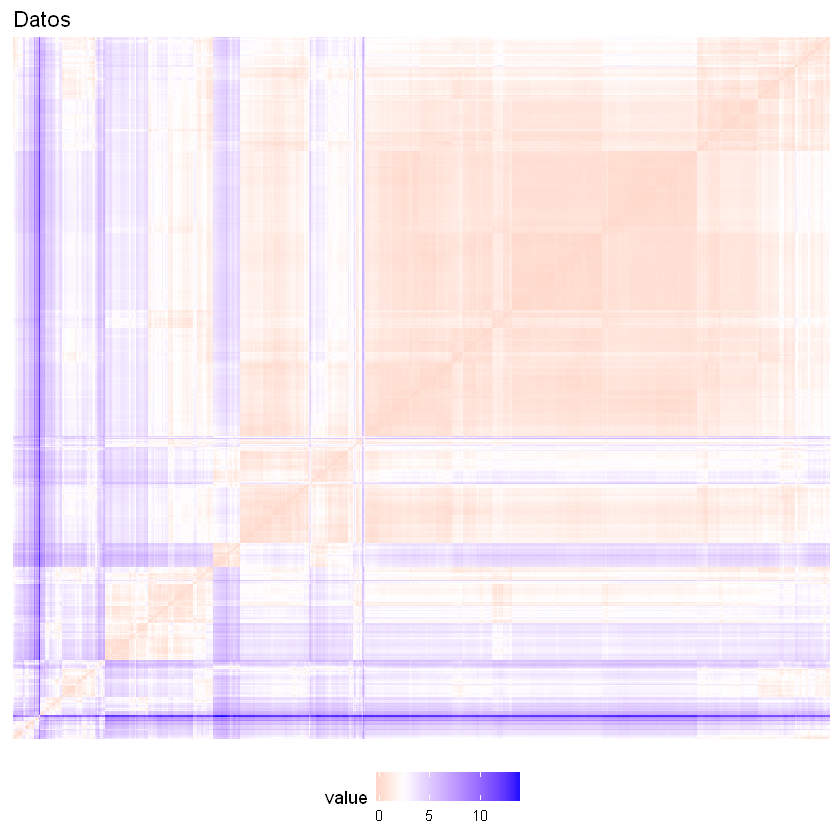

In [15]:
dist_datos <- dist(datos, method = "euclidean")
p1 <- fviz_dist(dist.obj = dist_datos, show_labels = FALSE) +
      labs(title = "Datos") + theme(legend.position = "bottom")
p1

El método VAT confirma que en el set de datos sí hay una estructura de grupos, por lo que es recomendable aplicar tecnicas de clustering para obtenerlos 

## Modelado

In [16]:
## DataFrame para alamacenar los resultados de las metricas calculadas para cada una de las tecnicas de clustering 

results <- data.frame(Algorithm=character(),
                 Strategy=character(), 
                 Distance=character(), 
                 Clusters=numeric(), 
                 Silhouette_Score=numeric(),
                 Cluster_Elements= character(),        
                 stringsAsFactors=FALSE) 

results


add_results <- function(results, algorithm, strategy="", distance="euclidean", stats){
  
   return ( results %>% add_row(Algorithm = algorithm, 
                      Strategy= strategy, 
                      Distance=distance, 
                      Clusters = stats$cluster.number , 
                      Silhouette_Score=stats$avg.silwidth,
                      Cluster_Elements=paste(sort(stats$cluster.size, decreasing = T),collapse="/")))
}

Algorithm,Strategy,Distance,Clusters,Silhouette_Score,Cluster_Elements


## 1 Algoritmo DBSCAN

DBSCAN es un algoritmo basado en densidad que recibe dos parametros, el primero corresponde a la cantidad de elementos minimos n que se requieren para formar el núcleo de un cluster. Para este parametro se utilizara un valor porcentual de los datos igual al 2.5% es decir que n = 46. El segundo parametro corresponde al radio de la vecindad que tiene cada punto.Este parametro puede ser muy sensible y complicado de encontrar un valor optimo, por lo que se realizaran diferentes pruebas tomando un rango de valores entre 0.05 y 3.0 con una separación de 0.075 entre cada valor.  

In [17]:
# Cálculo de min_pts
k <- 0.0020 # Porcentaje elegido. 
min_pts <- round(nrow(datos) * k) # Cálculo de min_pts. 
if (min_pts <= 1) { # Elimino la opción de un min_pts < 1 y limito su valor máximo.   
min_pts <- 2 } else if (min_pts >= 10) {
   min_pts <- 10
 }
min_pts

[1] 4

La función auto_eps() devuelve el valor del eje Y (eps) en el que se produce el valor de la pendiente m elegido

In [18]:
#epsilon <- auto_eps(datos, min_pts)
#epsilon

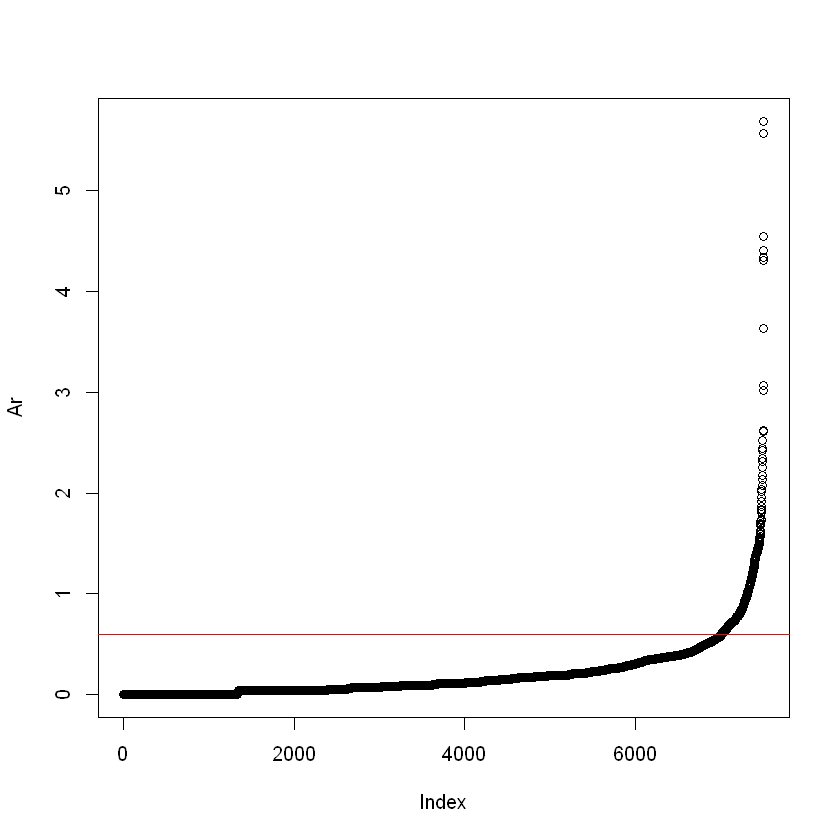

In [19]:
A <- dbscan::kNNdist(datos, k = min_pts)
Ar <- A[order(A)]
plot(Ar)
abline(h=0.6, col = "red", lty=7)

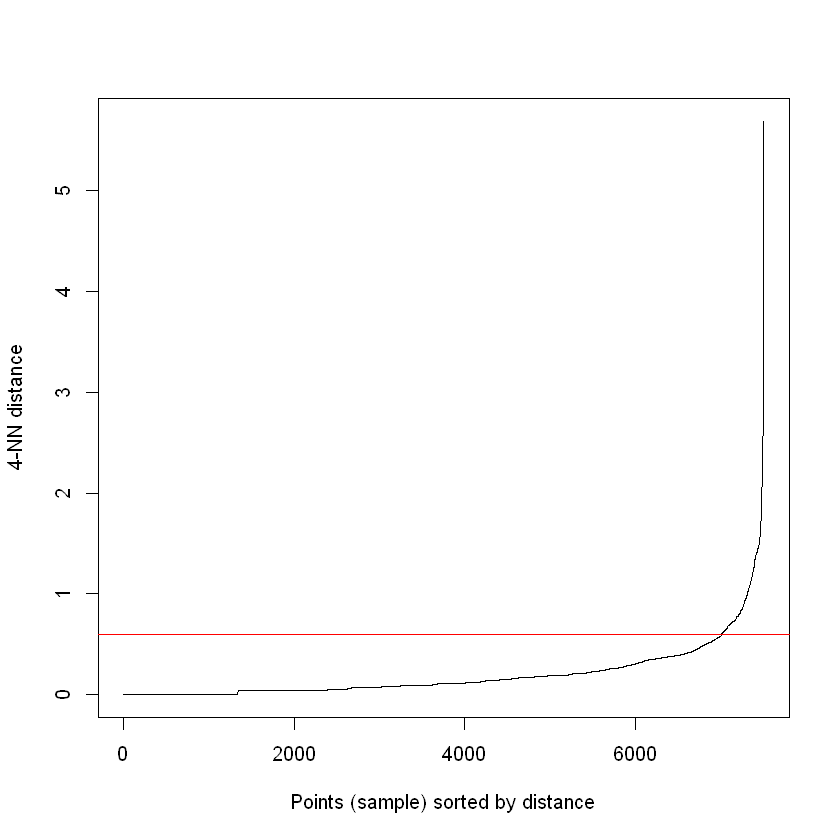

In [20]:
# Selección del valor óptimo de epsilon. Como valor de minPts se emplea 5.
dbscan::kNNdistplot(datos, k = min_pts)
abline(h=0.6, col = "red", lty=7)

In [21]:
set.seed(321)
# DBSCAN con epsilon = 0.6 y minPts = 4
dbscan_cluster <- fpc::dbscan(data = datos, eps = 0.6, MinPts = 4)

# Resultados de la asignación
print(dbscan_cluster)

dbscan Pts=1877 MinPts=4 eps=0.6
         0    1 2 3  4  5 6 7 8  9 10 11 12 13
border 105   20 2 0  0  2 4 0 0  3  0  1  0  2
seed     0 1644 1 9 10 13 2 4 4 26  5 13  5  2
total  105 1664 3 9 10 15 6 4 4 29  5 14  5  4


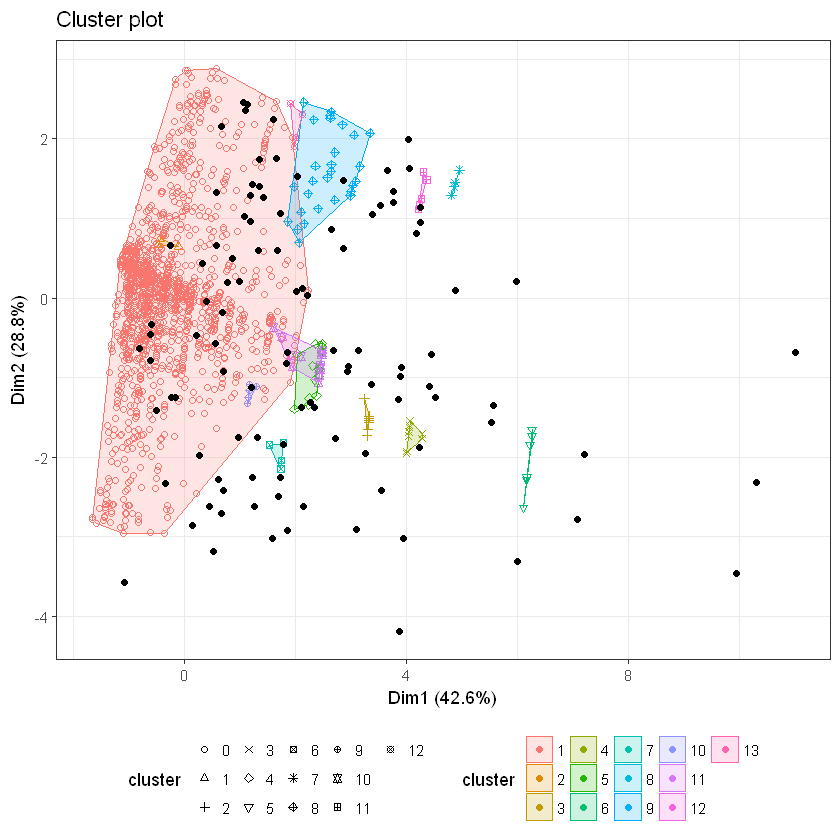

In [22]:
##Visualización de los clusters
fviz_cluster(object = dbscan_cluster, data = datos, stand = FALSE,
             geom = "point", ellipse = TRUE, show.clust.cent = FALSE,
             pallete = "jco") +
  theme_bw() +
  theme(legend.position = "bottom")


   0    1    2    3    4    5    6    7    8    9   10   11   12   13 
 105 1664    3    9   10   15    6    4    4   29    5   14    5    4 

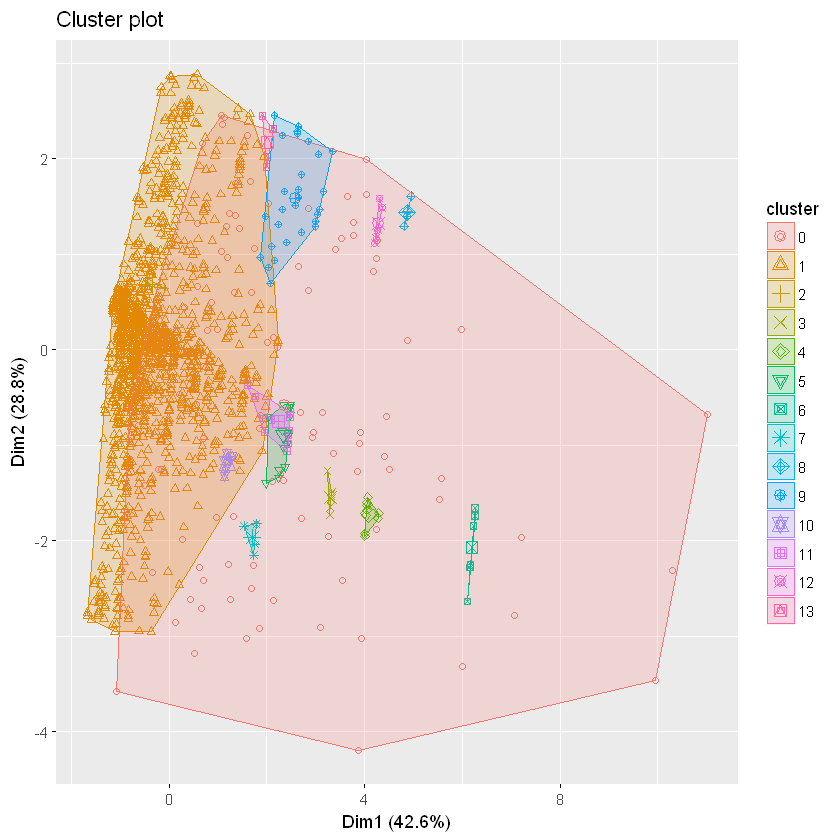

In [23]:
fviz_cluster(list(data = datos, cluster = dbscan_cluster$cluster), geom='point', pallete = "jco")
table(dbscan_cluster$cluster)


### Validación de la Calidad de los Cluster

#### Ancho de la Silueta

In [24]:
datos_ruidos <- as.data.frame(datos)
datos_ruidos$cluters <- dbscan_cluster$cluster

Silhouette of 1772 units in 13 clusters from silhouette.default(x = datos_ruidos[datos_ruidos$cluters != 0,  from     5], dist = dist(datos_ruidos[datos_ruidos$cluters != 0, 1:4])) :
 Cluster sizes and average silhouette widths:
     1664         3         9        10        15         6         4         4 
0.2047785 0.8533635 0.8278940 0.7471190 0.6184127 0.7760682 0.8133877 0.6755603 
       29         5        14         5         4 
0.1544963 0.8129131 0.6283644 0.5782304 0.6824747 
Individual silhouette widths:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.79775 -0.02047  0.36645  0.22635  0.50051  0.88270 

   cluster size ave.sil.width
1        1 1664          0.20
2        2    3          0.85
3        3    9          0.83
4        4   10          0.75
5        5   15          0.62
6        6    6          0.78
7        7    4          0.81
8        8    4          0.68
9        9   29          0.15
10      10    5          0.81
11      11   14          0.63
12      12    5          0.58
13      13    4          0.68


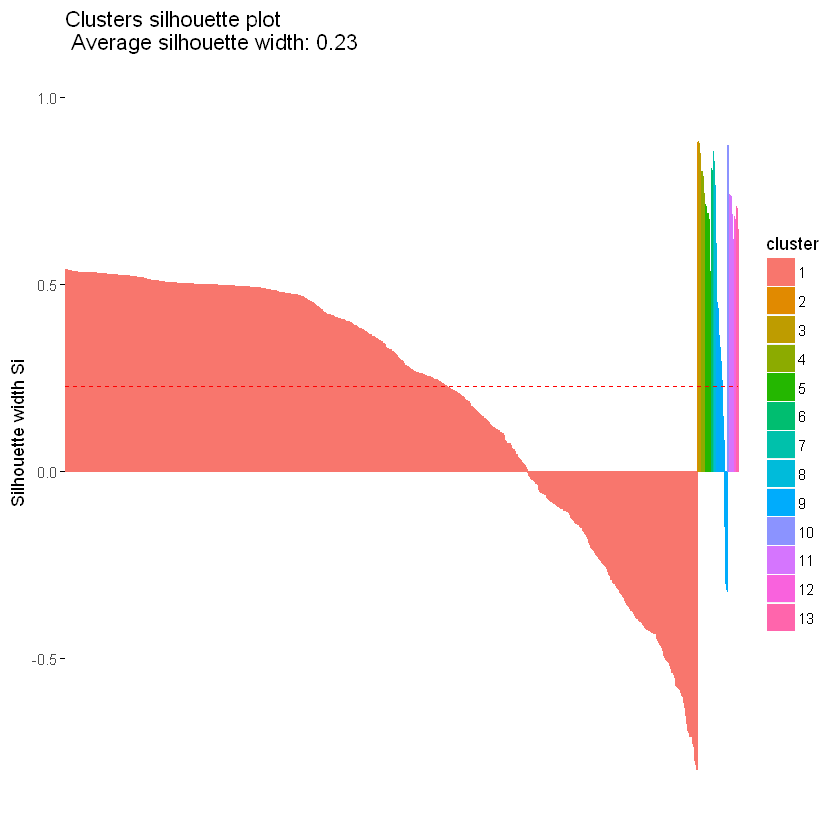

In [25]:
sil.km <- silhouette(datos_ruidos[datos_ruidos$cluters != 0,5], 
                     dist(datos_ruidos[datos_ruidos$cluters != 0,1:4]))

sil.sum <- summary(sil.km)
sil.sum

fviz_silhouette(sil.km)

#### Indice de Dunn

In [26]:
dd <- dist(datos_ruidos[datos_ruidos$cluters != 0,1:4], method = "euclidean")
dbscan_stats <- cluster.stats(dd, datos_ruidos[datos_ruidos$cluters != 0,5])
#km_stats$within.cluster.ss
#km_stats$clus.avg.silwidths
dbscan_stats$dunn

[1] 0.08464071

In [27]:
results<- add_results(results, algorithm="DBSCAN", strategy="", distance="euclidean", dbscan_stats)

## 2 Algoritmo basado en modelos

Decidir cuál es el método de clustering más adecuado para un determinado set de datos es un proceso complejo ya que se tienen que analizar uno a uno múltiples índices, estadísticos y parámetros (número de clusters, homogeneidad, separación, significancia…). El paquete clValid agiliza el proceso ofreciendo la posibilidad de comparar, de forma simultánea, múltiples algoritmos de clustering en una única función.

In [28]:
# Model-based-clustering
model_clustering <- Mclust(data = datos, G = 1:10)
summary(model_clustering)

----------------------------------------------------
Gaussian finite mixture model fitted by EM algorithm 
----------------------------------------------------

Mclust VEV (ellipsoidal, equal shape) model with 9 components:

 log.likelihood    n  df      BIC       ICL
      -3364.471 1877 110 -7558.06 -7913.487

Clustering table:
  1   2   3   4   5   6   7   8   9 
309 229 133 237 271  95 190 303 110 

In [29]:
# Grado de asignación a cada cluster
head(model_clustering$z)

1,9.767926e-01,0.0001068837,0.00000e+00,1.169155e-06,4.377783e-20,1.212094e-07,5.219175e-05,2.304694e-02,1.265580e-07
2,1.587825e-18,0.9272550987,0.00000e+00,2.082683e-03,4.490435e-02,4.482296e-05,2.522238e-02,4.442027e-08,4.906156e-04
3,1.140618e-05,0.0028163443,0.00000e+00,1.403111e-05,1.103474e-115,3.854853e-05,2.140105e-13,9.971172e-01,2.505753e-06
4,6.909189e-04,0.0027966055,9.96144e-01,1.657651e-04,3.068719e-26,1.121256e-05,1.194568e-04,7.132673e-05,7.123117e-07
5,5.947994e-115,0.0017100753,3.61550e-47,8.624921e-04,0.000000e+00,9.972443e-01,1.333676e-235,1.073598e-04,7.574454e-05
6,9.861009e-01,0.0002006618,0.00000e+00,1.473412e-06,1.112917e-03,2.959776e-08,9.382122e-08,1.258352e-02,3.824482e-07


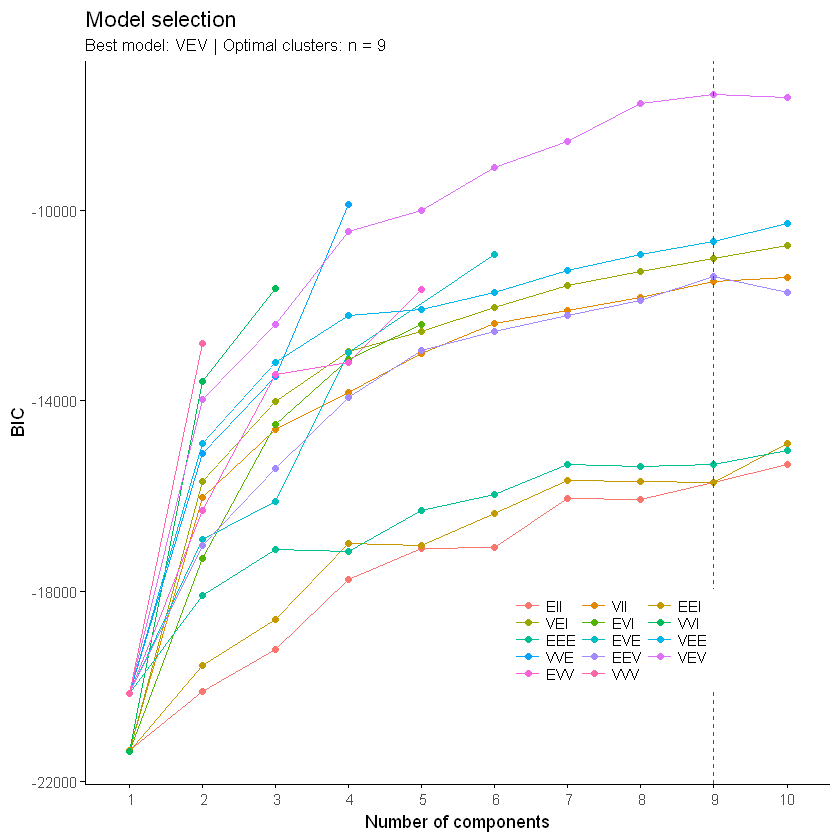

In [30]:
# Curvas del valor BIC en función del número de clusters para cada modelo.
# Atención al orden en el que se muestra la variable horizontal, por defecto es
# alfabético.
fviz_mclust(object = model_clustering, what = "BIC", pallete = "jco") +
  scale_x_discrete(limits = c(1:10))

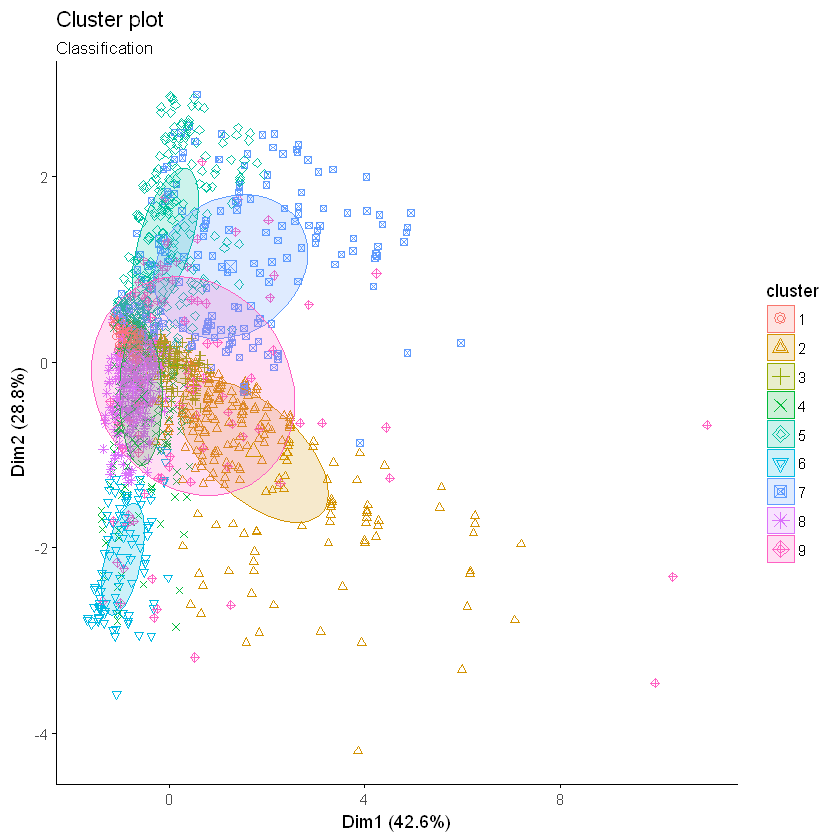

In [31]:
# Clusters
fviz_mclust(model_clustering, what = "classification", geom = "point",
            pallete = "jco")

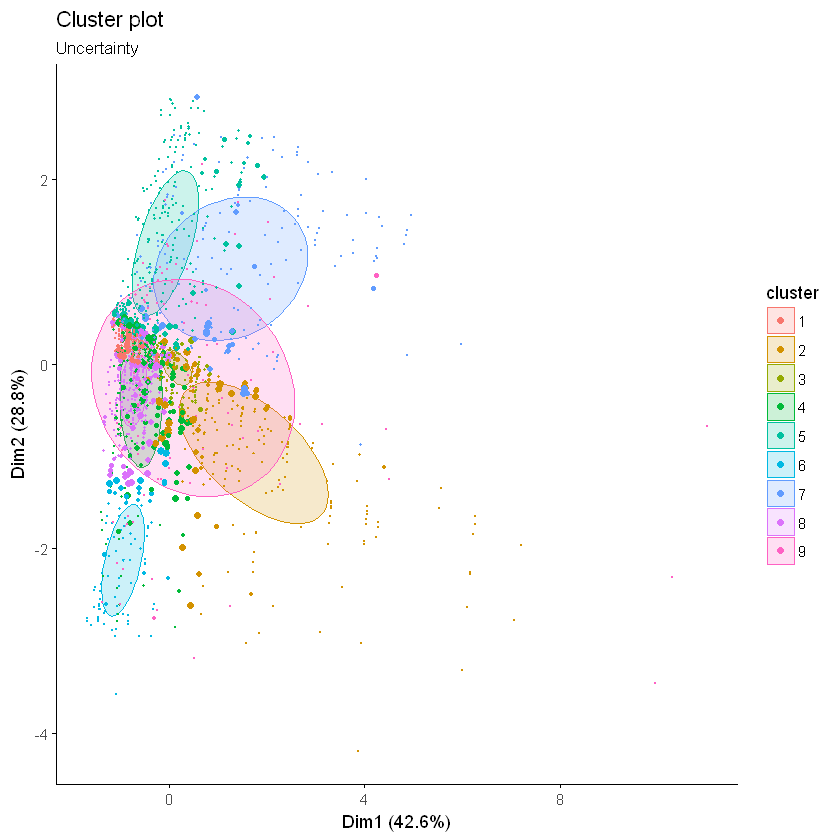

In [32]:
# Certeza de las clasificaciones. Cuanto mayor el tamaño del punto menor la
# seguridad de la asignación
fviz_mclust(model_clustering, what = "uncertainty", pallete = "jco")

### Validación de la Calidad de los Cluster

#### Ancho de la Silueta

Silhouette of 1877 units in 9 clusters from silhouette.default(x = model_clustering$classification, dist = dist(datos)) :
 Cluster sizes and average silhouette widths:
       309        229        133        237        271         95        190 
 0.6049894 -0.1656739  0.4562286 -0.4115903 -0.1405408  0.4570204 -0.2450452 
       303        110 
-0.0140443 -0.3501100 
Individual silhouette widths:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.86740 -0.36960  0.05883  0.01499  0.39349  0.68704 

  cluster size ave.sil.width
1       1  309          0.60
2       2  229         -0.17
3       3  133          0.46
4       4  237         -0.41
5       5  271         -0.14
6       6   95          0.46
7       7  190         -0.25
8       8  303         -0.01
9       9  110         -0.35


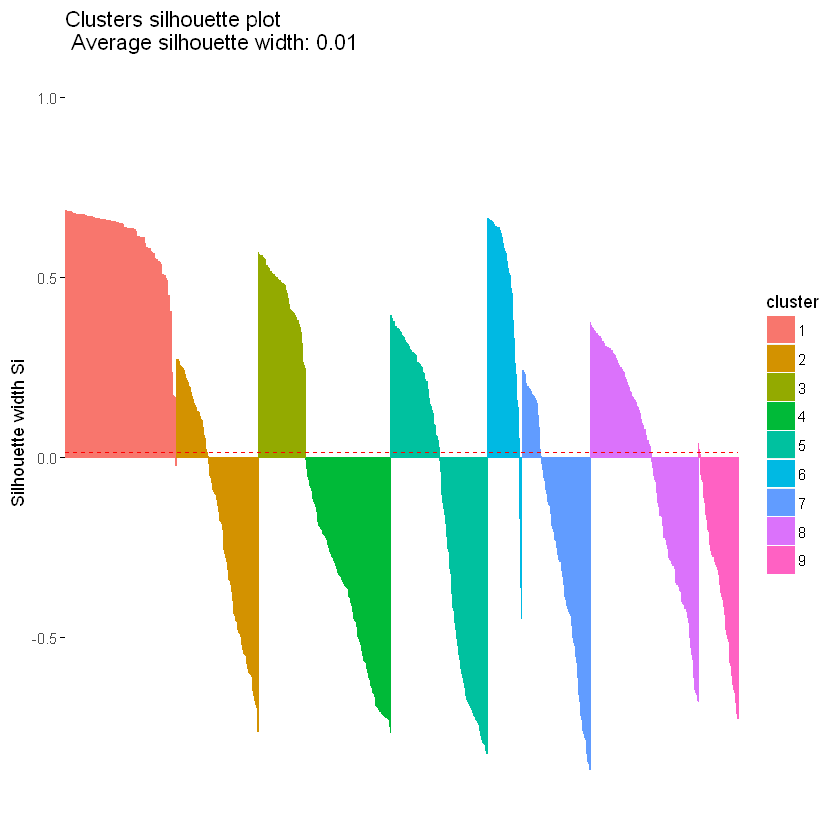

In [33]:
sil.km <- silhouette(model_clustering$classification, 
                     dist(datos))

sil.sum <- summary(sil.km)
sil.sum

fviz_silhouette(sil.km)

#### Indice de Dunn

In [34]:
dd <- dist(datos, method = "euclidean")
model_stats <- cluster.stats(dd, model_clustering$classification)
model_stats$dunn

[1] 0.002785985

In [35]:
results<- add_results(results, algorithm="Model", strategy="GMM", distance="euclidean", model_stats)

results

## 3 Algoritmo K-MEANS

Decidir cuál es el método de clustering más adecuado para un determinado set de datos es un proceso complejo ya que se tienen que analizar uno a uno múltiples índices, estadísticos y parámetros (número de clusters, homogeneidad, separación, significancia…). El paquete clValid agiliza el proceso ofreciendo la posibilidad de comparar, de forma simultánea, múltiples algoritmos de clustering en una única función.

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 


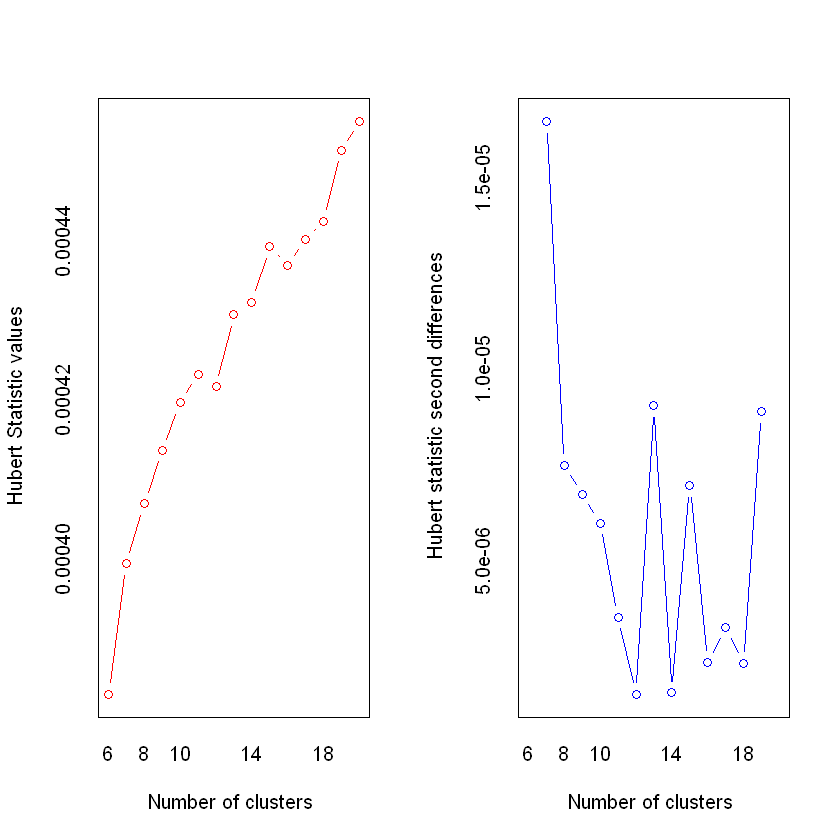

*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 6 proposed 6 as the best number of clusters 
* 11 proposed 7 as the best number of clusters 
* 1 proposed 16 as the best number of clusters 
* 1 proposed 18 as the best number of clusters 
* 1 proposed 19 as the best number of clusters 
* 3 proposed 20 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  7 
 
 
******************************************************************* 
Among all indices: 
* 2 proposed  0 as the best n

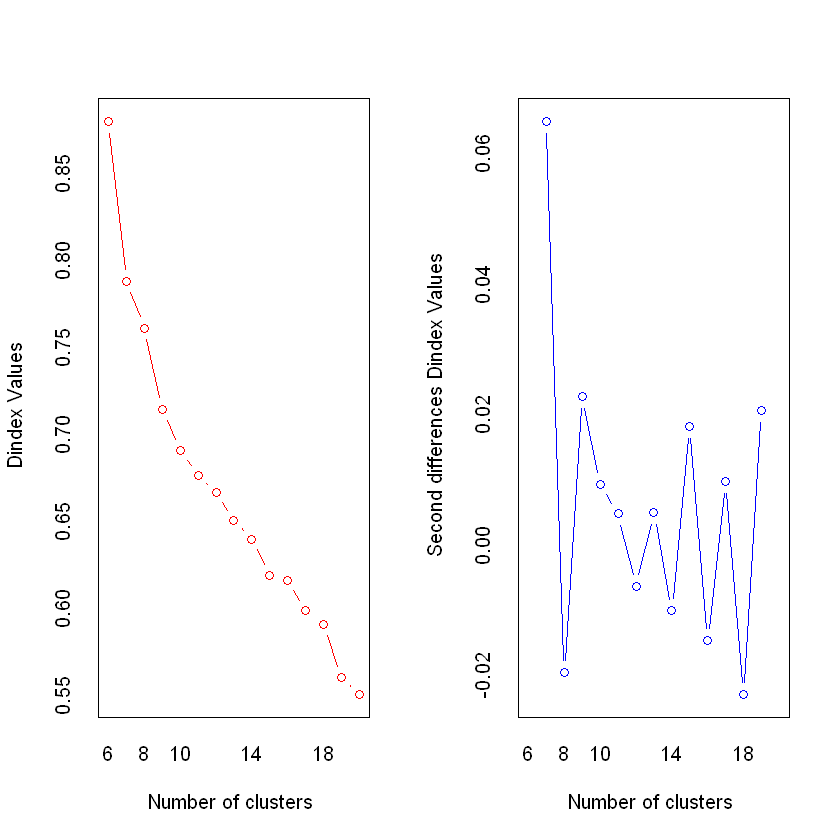

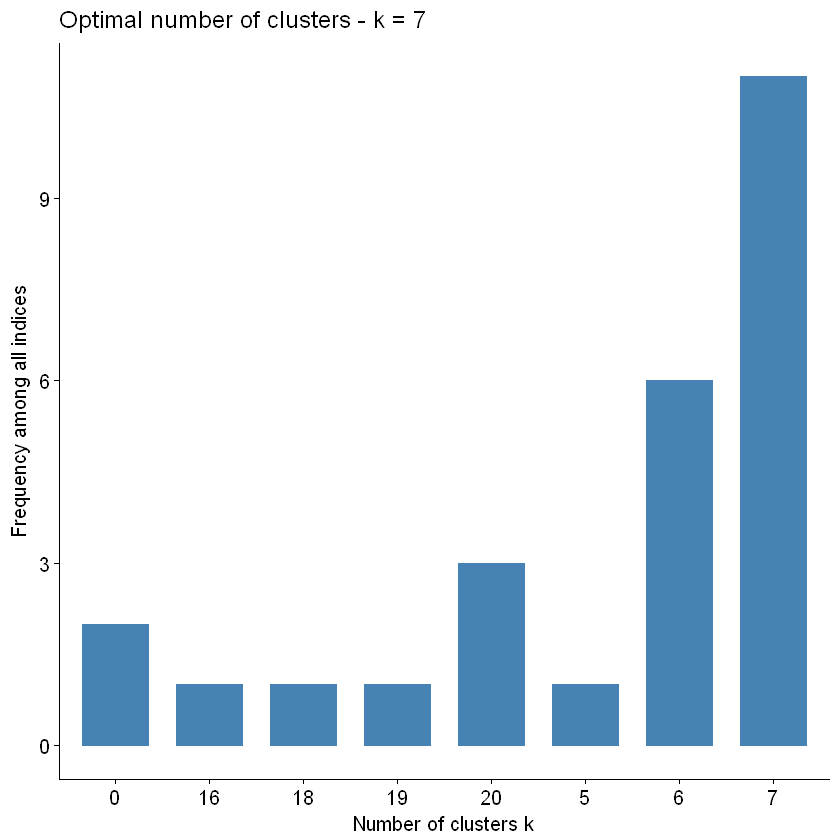

In [36]:
set.seed(321)
numero_clusters <- NbClust(data = datos, distance = "euclidean", min.nc = 6,
                           max.nc = 20, method = "kmeans", index = "all")

fviz_nbclust(numero_clusters)

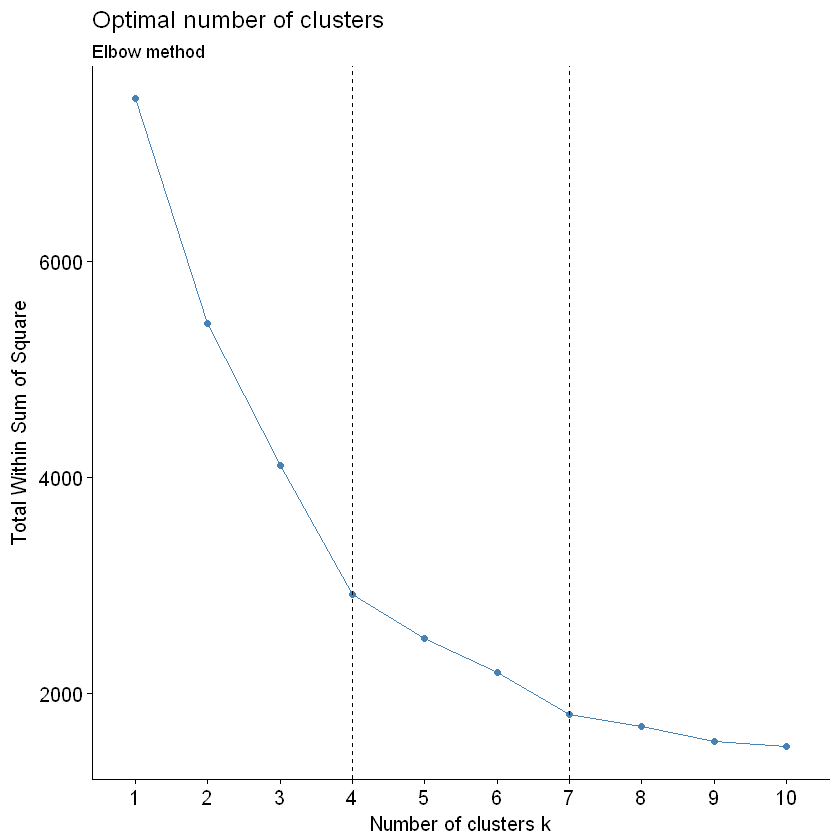

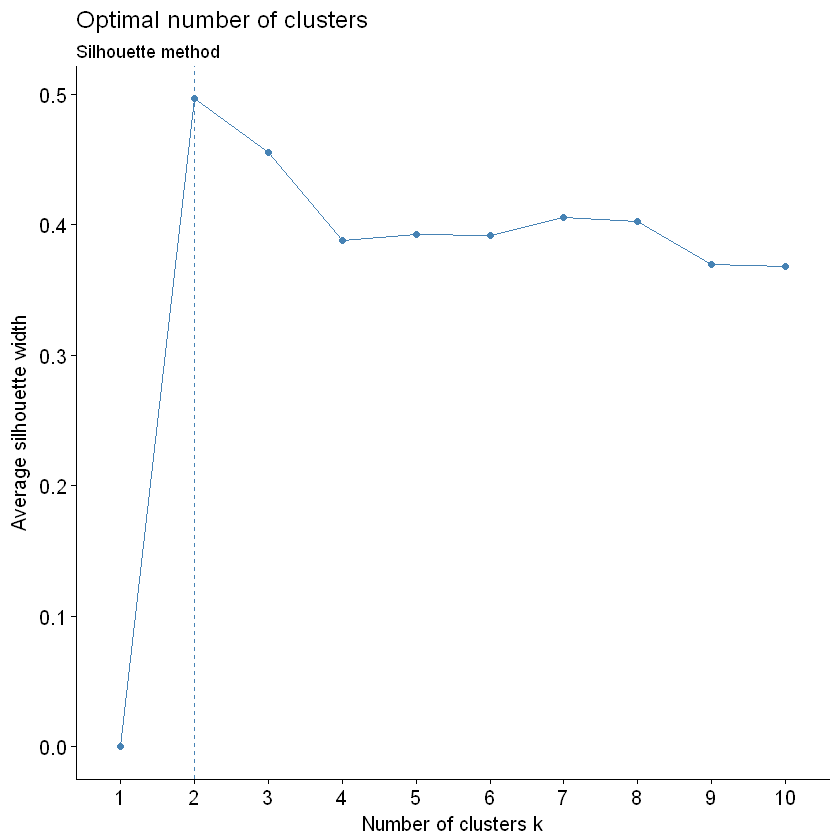

In [37]:
# Elbow method
fviz_nbclust(datos, kmeans, method = "wss") +
    geom_vline(xintercept = 4, linetype = 2)+
    geom_vline(xintercept = 7, linetype = 2)+
  labs(subtitle = "Elbow method")

# Silhouette method
fviz_nbclust(datos, kmeans, method = "silhouette", nboot = 100)+
  labs(subtitle = "Silhouette method")


[1] 1805.68



  1   2   3   4   5   6   7 
280  57 123  49 273 878 217 

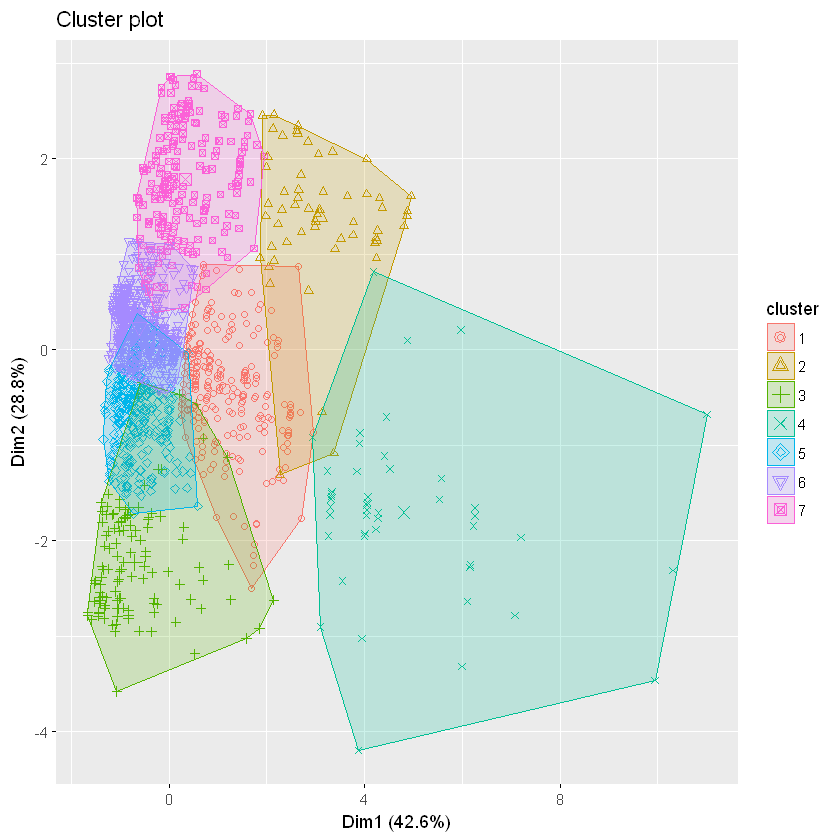

In [38]:
set.seed(18031)
km.res <- kmeans(datos, 7, nstart = 50)
fviz_cluster(km.res, data = datos, geom = "point")
print(km.res$tot.withinss)

dd <- dist(datos, method = "euclidean")
km_stats <- cluster.stats(dd, km.res$cluster)
table(km.res$cluster)

### Validación de la Calidad de los Cluster

#### Ancho de la Silueta

Silhouette of 1877 units in 7 clusters from silhouette.default(x = km.res$cluster, dist = dist(datos)) :
 Cluster sizes and average silhouette widths:
      280        57       123        49       273       878       217 
0.1712011 0.3604635 0.3447321 0.2442685 0.3451969 0.5185873 0.4077108 
Individual silhouette widths:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.1909  0.2650  0.4467  0.4054  0.5787  0.6708 

  cluster size ave.sil.width
1       1  280          0.17
2       2   57          0.36
3       3  123          0.34
4       4   49          0.24
5       5  273          0.35
6       6  878          0.52
7       7  217          0.41


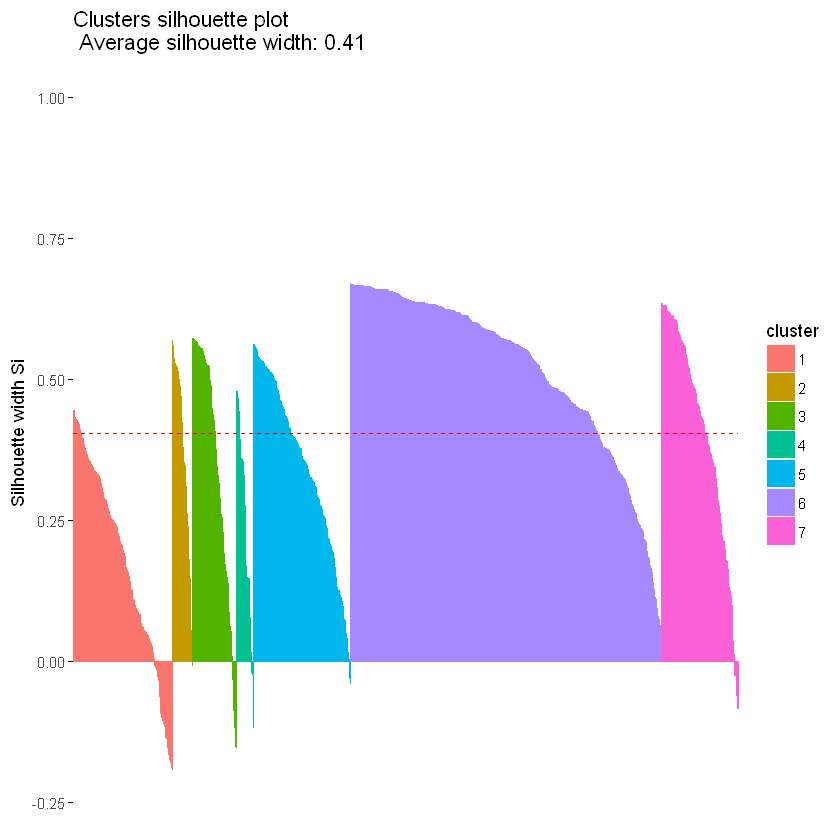

In [39]:
sil.km <- silhouette(km.res$cluster, 
                     dist(datos))

sil.sum <- summary(sil.km)
sil.sum

fviz_silhouette(sil.km)

#### Indice de Dunn

In [40]:
km.res <- kmeans(datos, 7, nstart = 50)
dd <- dist(datos, method = "euclidean")
km_stats <- cluster.stats(dd, km.res$cluster)
km_stats$dunn

[1] 0.003661477

In [41]:
results<- add_results(results, algorithm="K-means", strategy="", distance="euclidean", km_stats)

## 4 Algoritmo Jerarquico Aglomerativo

Con la función **agnes** se puede obtener el coeficiente de aglomeración, que mide la cantidad de estructura de agrupamiento encontrada (los valores más cercanos a 1 sugieren una estructura de agrupamiento fuerte).

In [42]:
# methods to assess
m <- c( "average", "single", "complete", "ward")
names(m) <- c( "average", "single", "complete", "ward")

# function to compute coefficient
ac <- function(x) {
  agnes(datos, method = x)$ac
}
map_dbl(m, ac)


average    single  complete      ward 
0.9809369 0.9696740 0.9888801 0.9975444

Aquí vemos que el método de Ward identifica la estructura de agrupamiento más sólida de los cuatro métodos evaluados.

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 


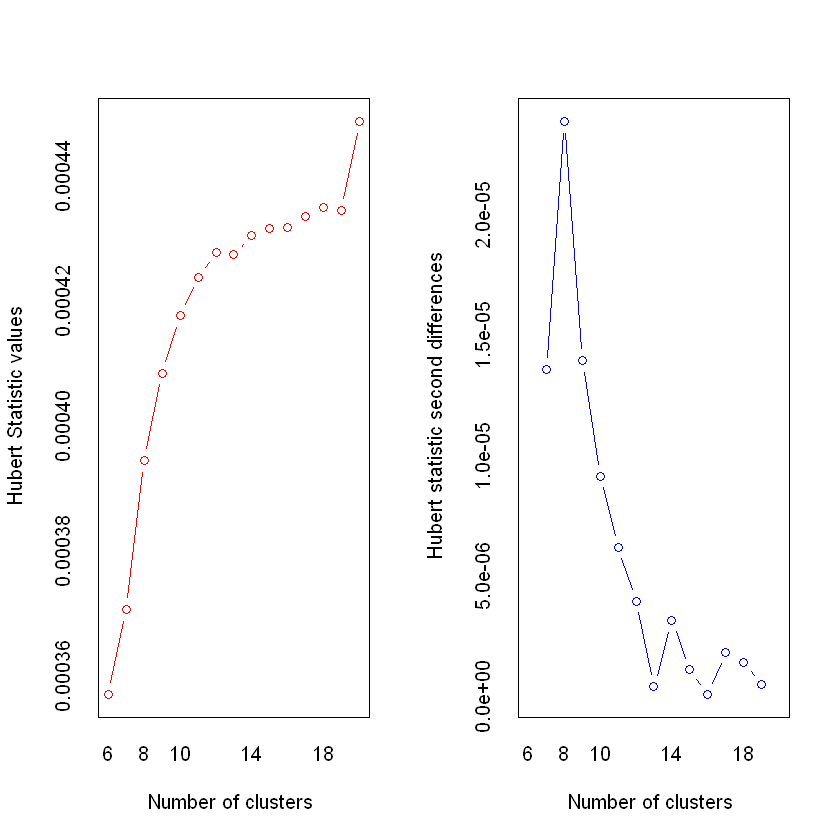

*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 5 proposed 6 as the best number of clusters 
* 2 proposed 7 as the best number of clusters 
* 6 proposed 8 as the best number of clusters 
* 4 proposed 9 as the best number of clusters 
* 3 proposed 10 as the best number of clusters 
* 1 proposed 13 as the best number of clusters 
* 1 proposed 19 as the best number of clusters 
* 2 proposed 20 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  8 
 
 
*************************

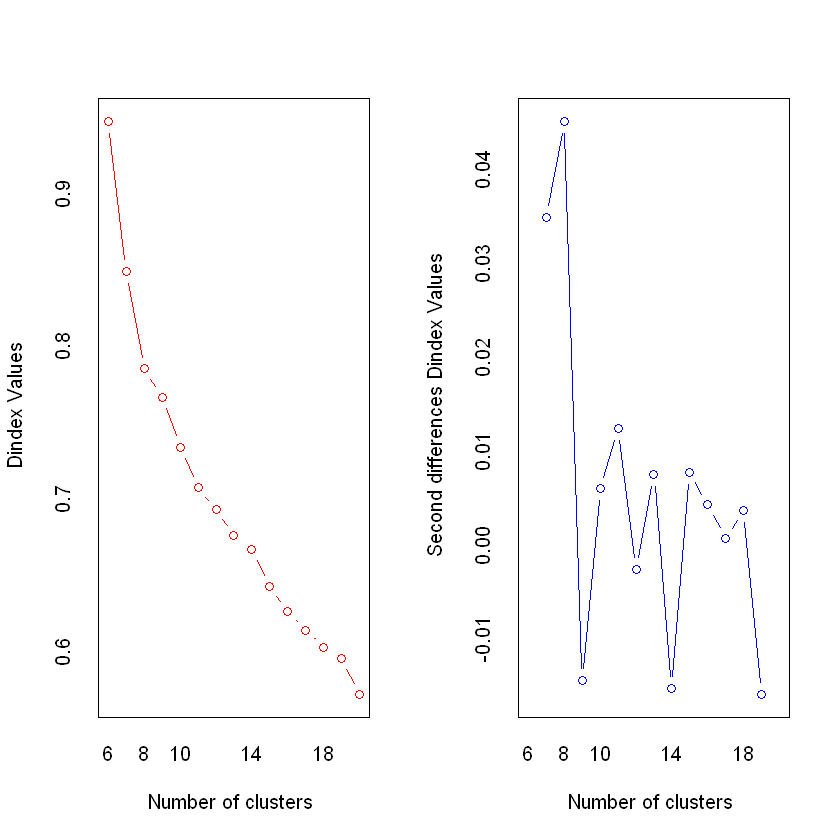

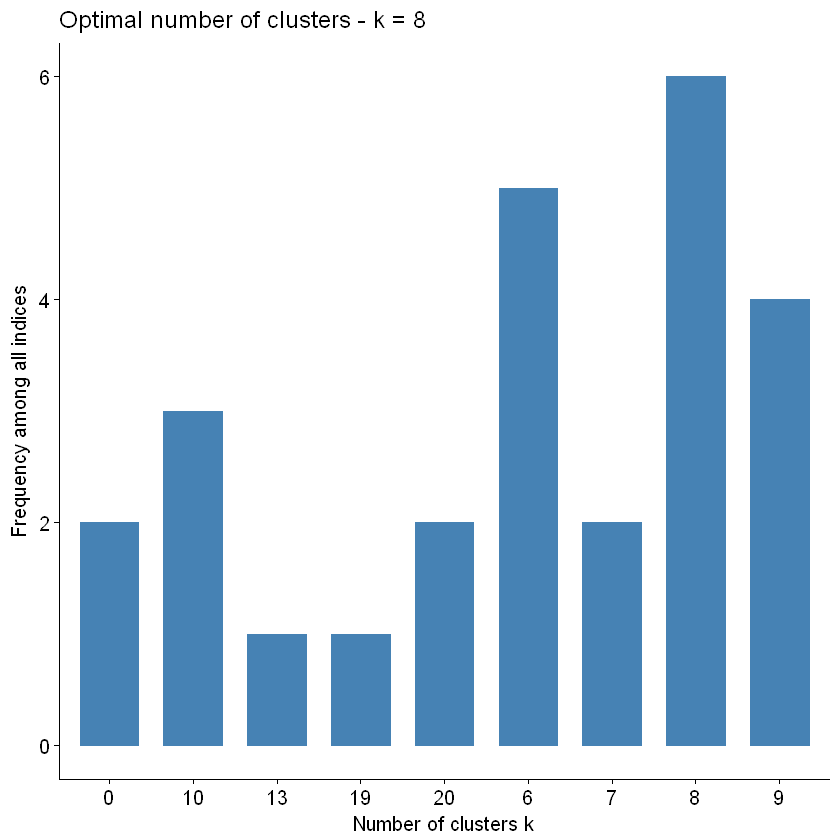

In [43]:
numero_clusters <- NbClust(data = datos, distance = "euclidean", min.nc = 6,
                           max.nc = 20, method = "ward.D2", index = "all")

fviz_nbclust(numero_clusters)

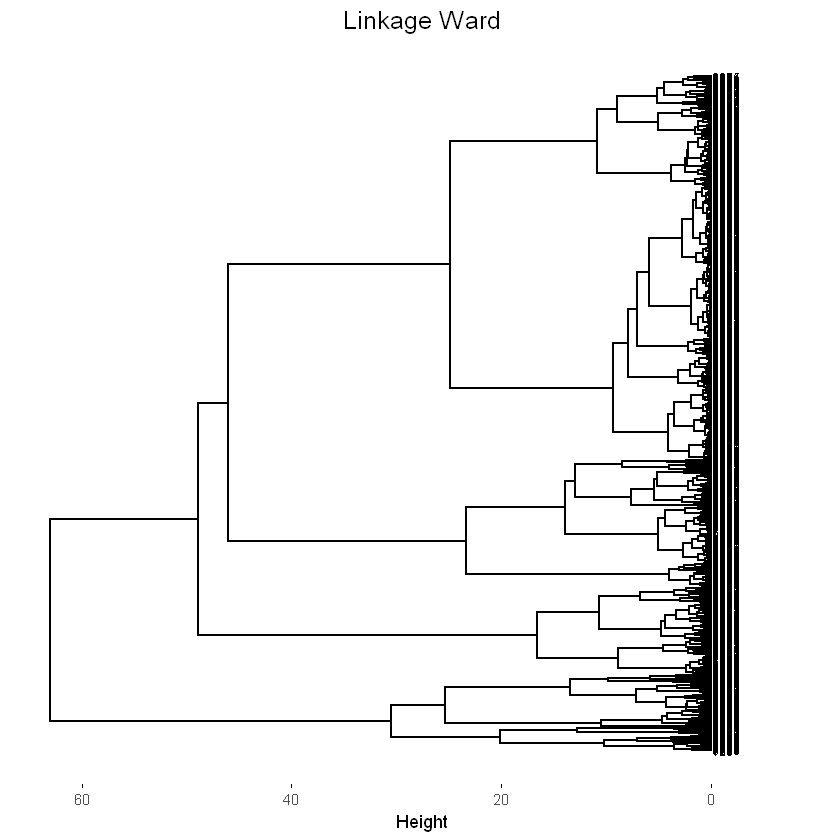

In [44]:
set.seed(101)
hc_euclidea_completo <- hclust(d = dist(x = datos, method = "euclidean"),
                               method = "ward.D2")
fviz_dend(x = hc_euclidea_completo, 
          cex = 0.5, 
 
         
          rect = TRUE,
          rect_fill = TRUE,
          horiz = TRUE,
           
          ,main = "Linkage Ward",
          sub = "Distancia euclídea") +
  theme(plot.title =  element_text(hjust = 0.5, size = 15))

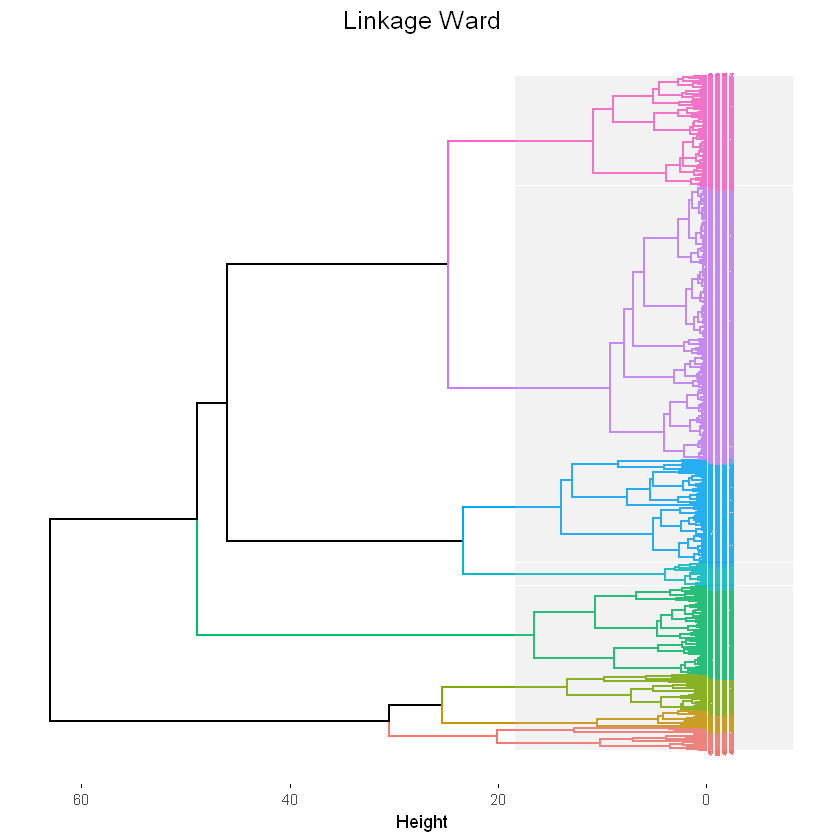

In [45]:
# Se obtiene el dendrograma de hierarchical clustering para elegir el número de
# clusters.
set.seed(101)
hc_euclidea_completo <- hclust(d = dist(x = datos, method = "euclidean"),
                               method = "ward.D2")
fviz_dend(x = hc_euclidea_completo, 
          cex = 0.5, 
          k = 8, 
          color_labels_by_k = TRUE,
          rect = TRUE,
          rect_fill = TRUE,
          horiz = TRUE,
           
          ,main = "Linkage Ward",
          sub = "Distancia euclídea") +
  theme(plot.title =  element_text(hjust = 0.5, size = 15))

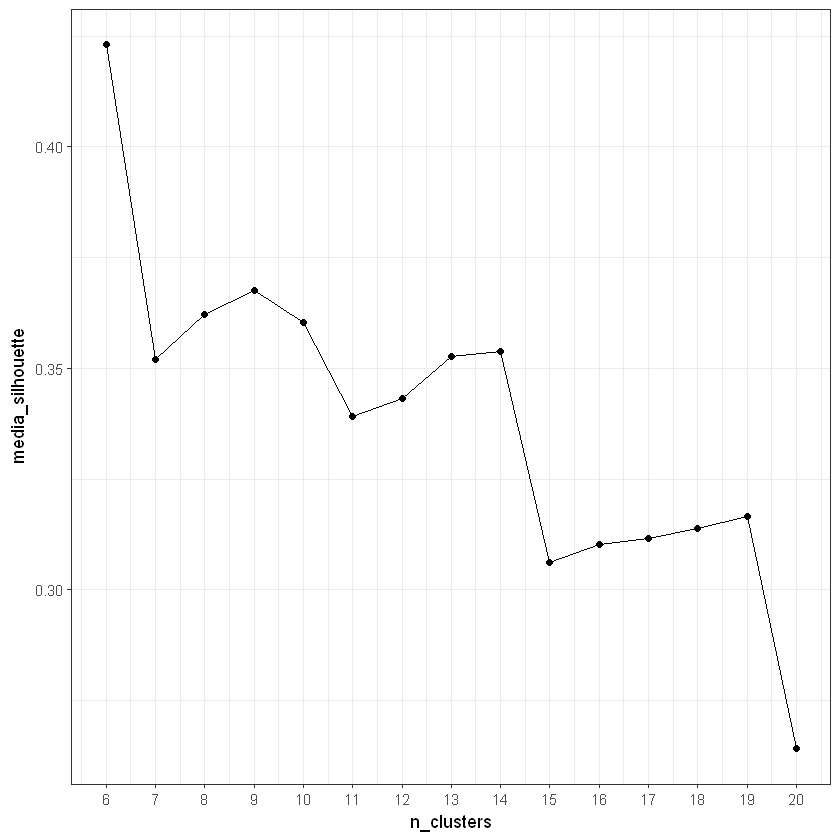

In [46]:
# ÍNDICES SILUETA HIERARCHICAL CLUSTERING
# ==============================================================================

custom_silhouette <- function(n_clusters, dendograma, distancia, datos){
  # Esta función calcula el indice silueta medio de un dendograma
  # para un determinado número de clusters.
  set.seed(123)
  valores_silhouette <- cluster::silhouette(stats::cutree(dendograma,
                                                          k = n_clusters),
                                           get_dist(x = datos, method = distancia))
  media_silhouette <- summary(valores_silhouette)[[4]]
  return(media_silhouette)
}

hc_euclidea_ward<- hclust(d = dist(x = datos, method = "euclidean"),
                               method = "ward.D2")
valores_medios_silhouette <- map_dbl(.x = 6:20,
                                     .f = custom_silhouette,
                                     dendograma = hc_euclidea_ward,
                                     distancia = "euclidean",
                                     datos = datos)

data.frame(n_clusters = 6:20, media_silhouette = valores_medios_silhouette) %>%
  ggplot(aes(x = n_clusters, y = media_silhouette)) +
    geom_line() +
    geom_point() +
    scale_x_continuous(breaks = 6:20) +
    theme_bw()

In [47]:
# Cortamos en 8 grupos 
sub_grp <- cutree(hc_euclidea_completo, k = 8)

# Numero de elementos por cada cluster 
table(sub_grp)

sub_grp
  1   2   3   4   5   6   7   8 
762 306 287 247  64  62 100  49 

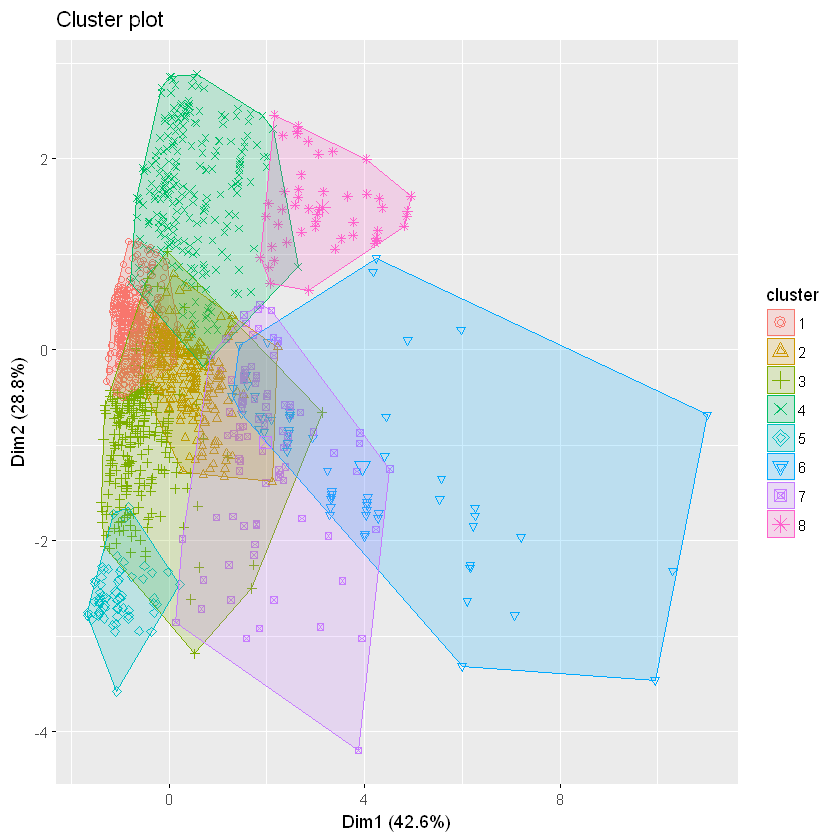

In [48]:
fviz_cluster(list(data = datos, cluster = sub_grp), geom = "point")

### Validación de la Calidad de los Cluster

#### Ancho de la Silueta

Silhouette of 1877 units in 8 clusters from silhouette.default(x = sub_grp, dist = dist(datos)) :
 Cluster sizes and average silhouette widths:
      762       306       287       247        64        62       100        49 
0.5532280 0.2248692 0.1057124 0.2807700 0.6714152 0.1317346 0.1749548 0.4266671 
Individual silhouette widths:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.5843  0.2046  0.4084  0.3621  0.5968  0.7745 

  cluster size ave.sil.width
1       1  762          0.55
2       2  306          0.22
3       3  287          0.11
4       4  247          0.28
5       5   64          0.67
6       6   62          0.13
7       7  100          0.17
8       8   49          0.43


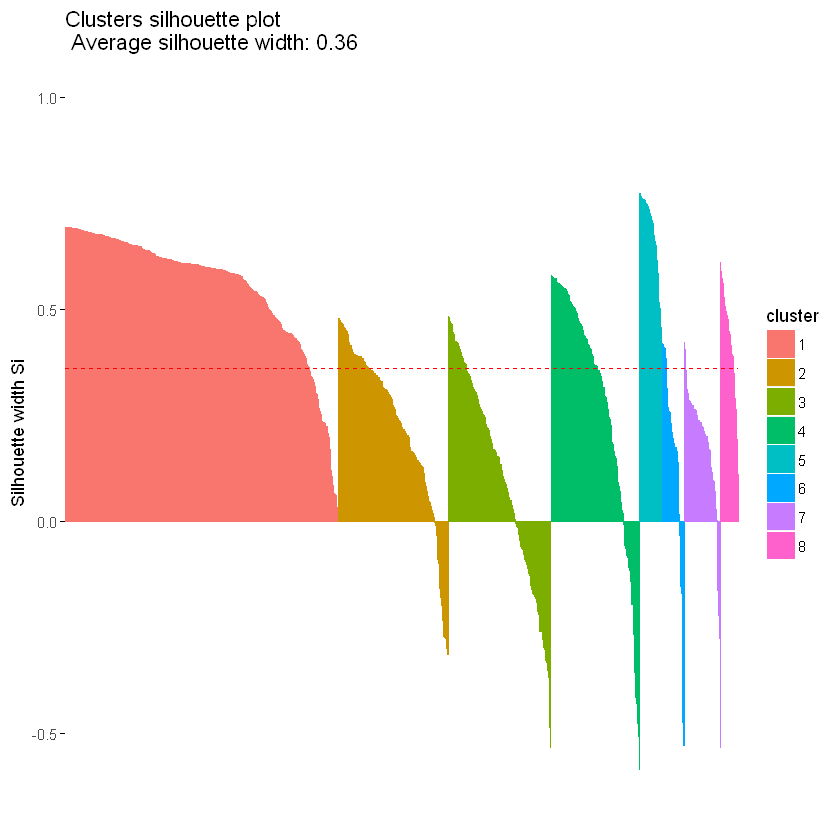

In [49]:
sil.km <- silhouette(sub_grp, 
                     dist(datos))

sil.sum <- summary(sil.km)
sil.sum

fviz_silhouette(sil.km)

#### Indice de Dunn

In [50]:
dd <- dist(datos, method = "euclidean")
h_stats <- cluster.stats(dd, sub_grp)
h_stats$dunn

[1] 0.01105303

In [51]:
results<- add_results(results, algorithm="Agglomerative", strategy="Ward", distance="euclidean", h_stats)

## Selección del algoritmo a utilizar

In [52]:
results

Algorithm,Strategy,Distance,Clusters,Silhouette_Score,Cluster_Elements
DBSCAN,,euclidean,13,0.22634603,1664/29/15/14/10/9/6/5/5/4/4/4/3
Model,GMM,euclidean,9,0.01499103,309/303/271/237/229/190/133/110/95
K-means,,euclidean,7,0.40537324,878/280/273/217/123/57/49
Agglomerative,Ward,euclidean,8,0.36206693,762/306/287/247/100/64/62/49


Tanto el algoritmo de k-means como el algoritmo jerárquico aglomerativo ofrecen valores de la silueta por encima del 0.25 y ambos algoritmos manejan una buena proporción en la distribución de los elementos de cada agrupación. De esta forma, el algoritmo que nos entrega la mejor relación entre el índice de la silueta y la distribución de los elementos por grupo, junto con que posee la menor dispersión entre los promedios de silueta de cada grupo en comparación a los otros algoritmos, fue K-Means con k = 7.

# Análisis de los Clústeres Encontrados

Se aplica el algoritmo K-Means con k=7 seleccionado como el mejor en la sección anterior 

In [53]:
set.seed(18031)
km.res <- kmeans(datos, 7, nstart = 50)

datos_agrupados <- data %>% mutate(grupo = km.res$cluster)
head(datos_agrupados, 5)


VMName,RAM,RAM_percentage,RAM_LastAvgUse_Gb_SD,CPUCount,CPU_percentage,CPU_LastAvgUse_MHz_SD,NETWORK_LastInboundAvgUse_Kbps_P95,NETWORK_LastInboundAvgUse_Kbps_SD,NETWORK_LastOutboundAvgUse_Kbps_P95,NETWORK_LastOutboundAvgUse_Kbps_SD,grupo
1000095_WINDOWS_SERVER_2012_R2_DATACENTER_64Bits,4,100,1,2,9,331,90,38,62,78,6
100634_FUNDACION_CIDCA_WIN_2003_32BIT_NEW (8f6e8a9c-c313-4a0a-9ba7-6573eae022d8),24,100,0,12,1,158,0,0,0,1,1
1006695_WINDOWS_SERVER_2016_DATACENTER_64 (55f438ca-6813-43df-83fa-892ea2c0b78d),4,100,0,2,21,337,0,19,0,1,6
100854_SERFIN_Contardocloud (07200194-5a6a-4629-9242-d17b265099e0),8,100,0,8,10,585,5,7,7,13,6
100854_SERFIN_Contardocloud_0501,8,100,0,8,71,5810,34,13,20,9,3


In [54]:
datos_agrupados <- data[,features] %>% mutate(grupo = km.res$cluster)
head(datos_agrupados, 5)


RAM,RAM_percentage,CPUCount,CPU_percentage,grupo
4,100,2,9,6
24,100,12,1,1
4,100,2,21,6
8,100,8,10,6
8,100,8,71,3


In [55]:
library(lattice)

datos_agrupados$grupo <- factor(datos_agrupados$grupo,
                               levels = c(1,2,3,4,5,6,7),
                               labels = c("G1","G2","G3","G4","G5","G6","G7"))



In [56]:
trellis.par.set(theme=col.whitebg())

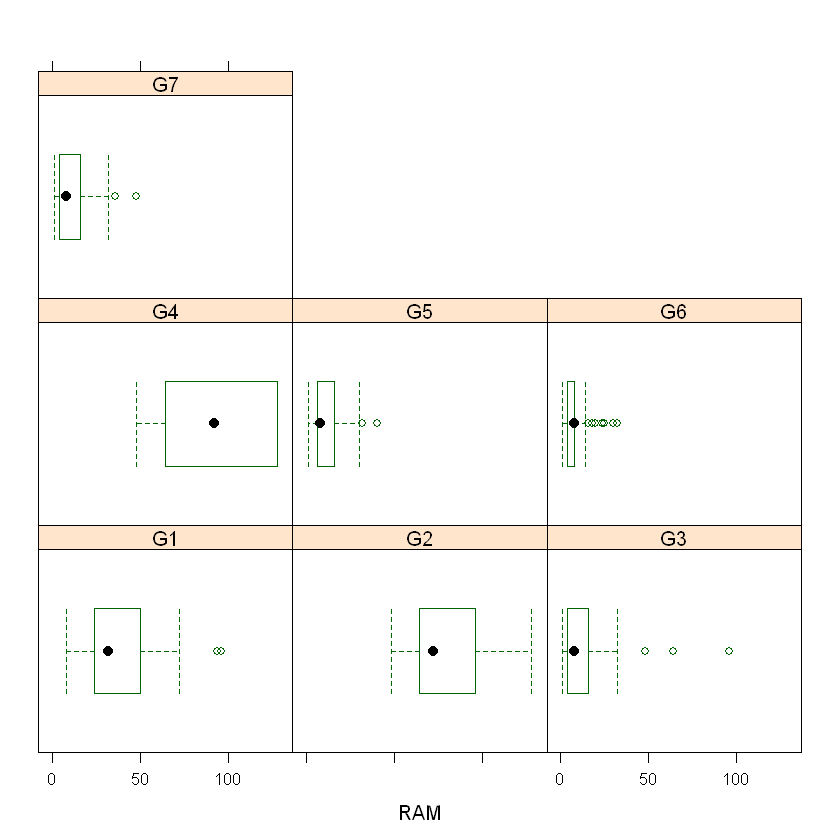

In [57]:
bwplot( ~ RAM | datos_agrupados$grupo,   data = datos_agrupados)


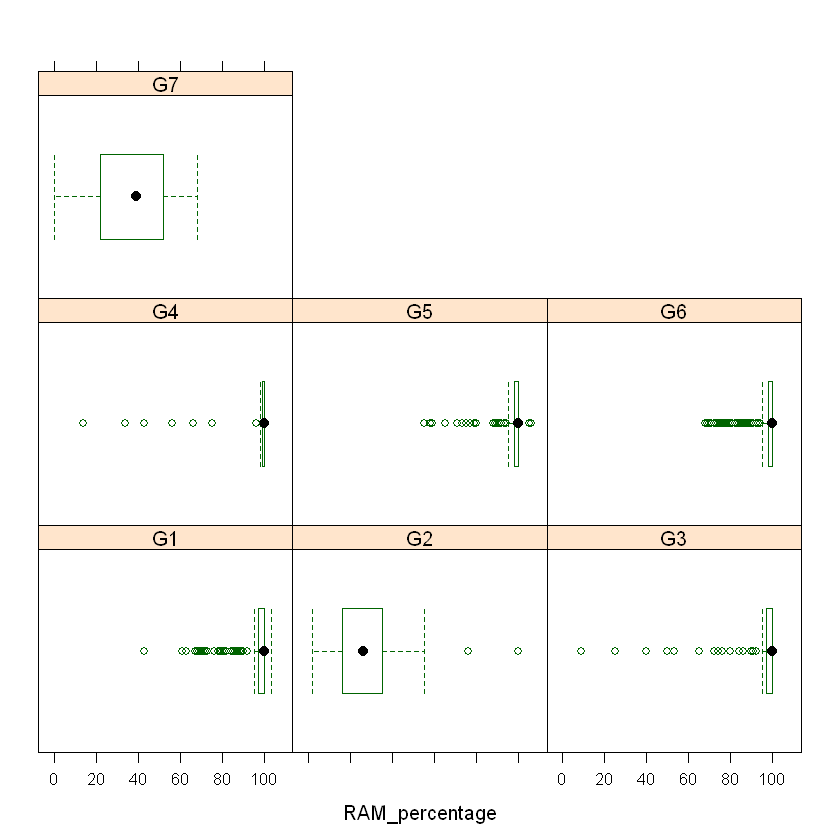

In [58]:
bwplot( ~ RAM_percentage | datos_agrupados$grupo,   data = datos_agrupados)

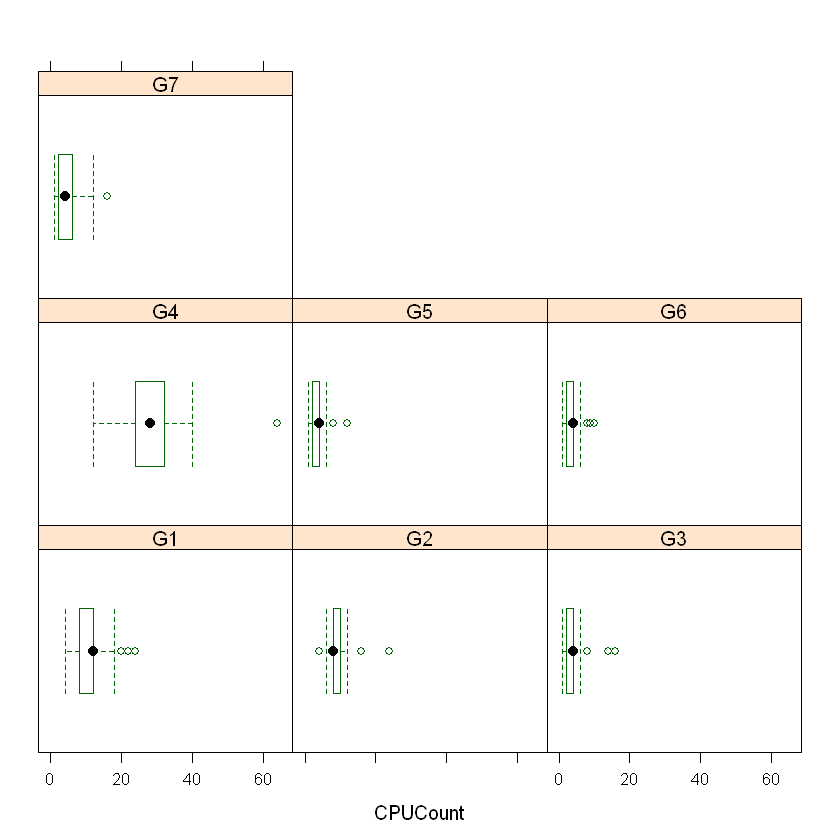

In [59]:
bwplot( ~ CPUCount | datos_agrupados$grupo,   data = datos_agrupados)

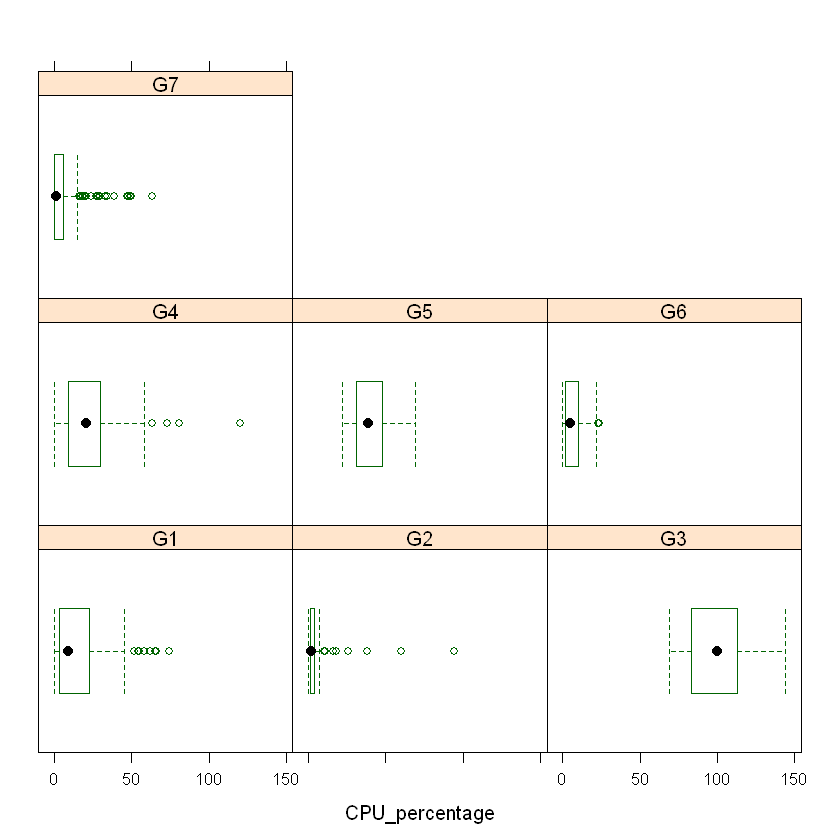

In [60]:
bwplot( ~ CPU_percentage | datos_agrupados$grupo,   data = datos_agrupados)

## Clasificación Consumos

In [61]:
datos_agrupados$ram_consumo <- cut(datos_agrupados$RAM_percentage,
                                breaks = c(0,5,25,75,95,107),
                                labels = c("Muy Bajo","Bajo","Medio","Alto","Muy Alto"),
                                right = F)


datos_agrupados$cpu_consumo <- cut(datos_agrupados$CPU_percentage,
                                   breaks = c(0,5,25,75,95,145),
                                   labels = c("Muy Bajo","Bajo","Medio","Alto","Muy Alto"),
                                  right = F)


datos_agrupados$ram_aprov <- cut(datos_agrupados$RAM,
                                   breaks = c(1,16,32,129),
                                   labels = c("Baja","Media","Alta"),
                                   right = F)


datos_agrupados$cpu_aprov <- cut(datos_agrupados$CPUCount,
                                   breaks = c(1,8,24,65),
                                   labels = c("Baja","Media","Alta"),
                                   right = F)

head(datos_agrupados)

RAM,RAM_percentage,CPUCount,CPU_percentage,grupo,ram_consumo,cpu_consumo,ram_aprov,cpu_aprov
4,100,2,9,G6,Muy Alto,Bajo,Baja,Baja
24,100,12,1,G1,Muy Alto,Muy Bajo,Media,Media
4,100,2,21,G6,Muy Alto,Bajo,Baja,Baja
8,100,8,10,G6,Muy Alto,Bajo,Baja,Media
8,100,8,71,G3,Muy Alto,Medio,Baja,Media
2,100,2,0,G6,Muy Alto,Muy Bajo,Baja,Baja


## Grupo 1

In [62]:
gp <- "G1"

In [63]:
print(gp)
datos_grupo <- subset(datos_agrupados, grupo == gp )
print(summary(datos_grupo))
tabla <- table(datos_grupo$cpu_consumo,datos_grupo$ram_consumo )
print(tabla)

[1] "G1"
      RAM        RAM_percentage      CPUCount     CPU_percentage  grupo   
 Min.   : 8.00   Min.   : 43.00   Min.   : 4.00   Min.   : 0.00   G1:280  
 1st Qu.:24.00   1st Qu.: 97.00   1st Qu.: 8.00   1st Qu.: 3.00   G2:  0  
 Median :32.00   Median :100.00   Median :12.00   Median : 9.00   G3:  0  
 Mean   :37.63   Mean   : 95.27   Mean   :11.26   Mean   :14.07   G4:  0  
 3rd Qu.:50.00   3rd Qu.:100.00   3rd Qu.:12.00   3rd Qu.:22.25   G5:  0  
 Max.   :96.00   Max.   :103.00   Max.   :24.00   Max.   :74.00   G6:  0  
                                                                  G7:  0  
   ram_consumo    cpu_consumo  ram_aprov   cpu_aprov  
 Muy Bajo:  0   Muy Bajo: 87   Baja : 25   Baja : 20  
 Bajo    :  0   Bajo    :133   Media: 71   Media:247  
 Medio   : 17   Medio   : 60   Alta :184   Alta : 13  
 Alto    : 41   Alto    :  0                          
 Muy Alto:222   Muy Alto:  0                          
                                                      
      

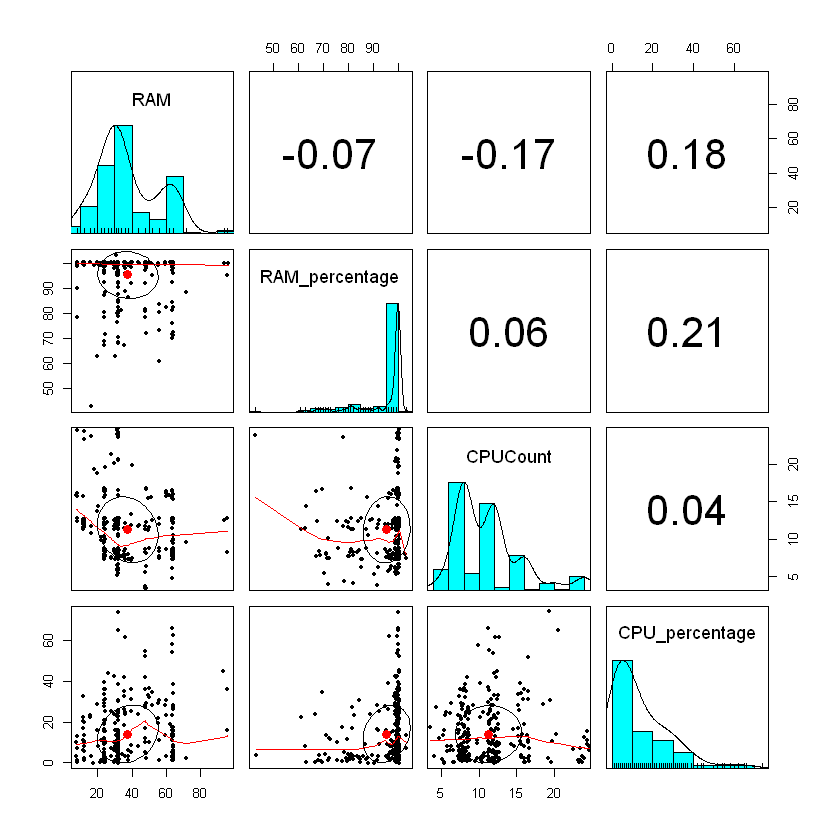

In [64]:
pairs.panels(subset(datos_agrupados, grupo == gp, select = RAM:CPU_percentage), rug = T, jiggle = T,ellipses = T)

## Grupo 2

In [65]:
gp <- "G2"

In [66]:
print(gp)
datos_grupo <- subset(datos_agrupados, grupo == gp )
print(summary(datos_grupo))
tabla <- table(datos_grupo$cpu_consumo,datos_grupo$ram_consumo )
print(tabla)

[1] "G2"
      RAM         RAM_percentage      CPUCount      CPU_percentage  grupo  
 Min.   : 48.00   Min.   :  2.00   Min.   : 4.000   Min.   : 0.00   G1: 0  
 1st Qu.: 64.00   1st Qu.: 16.00   1st Qu.: 8.000   1st Qu.: 1.00   G2:57  
 Median : 72.00   Median : 26.00   Median : 8.000   Median : 2.00   G3: 0  
 Mean   : 82.54   Mean   : 26.21   Mean   : 9.333   Mean   : 6.93   G4: 0  
 3rd Qu.: 96.00   3rd Qu.: 35.00   3rd Qu.:10.000   3rd Qu.: 4.00   G5: 0  
 Max.   :128.00   Max.   :100.00   Max.   :24.000   Max.   :94.00   G6: 0  
                                                                    G7: 0  
   ram_consumo   cpu_consumo ram_aprov  cpu_aprov 
 Muy Bajo: 4   Muy Bajo:43   Baja : 0   Baja :10  
 Bajo    :23   Bajo    :10   Media: 0   Media:46  
 Medio   :28   Medio   : 3   Alta :57   Alta : 1  
 Alto    : 1   Alto    : 1                        
 Muy Alto: 1   Muy Alto: 0                        
                                                  
                          

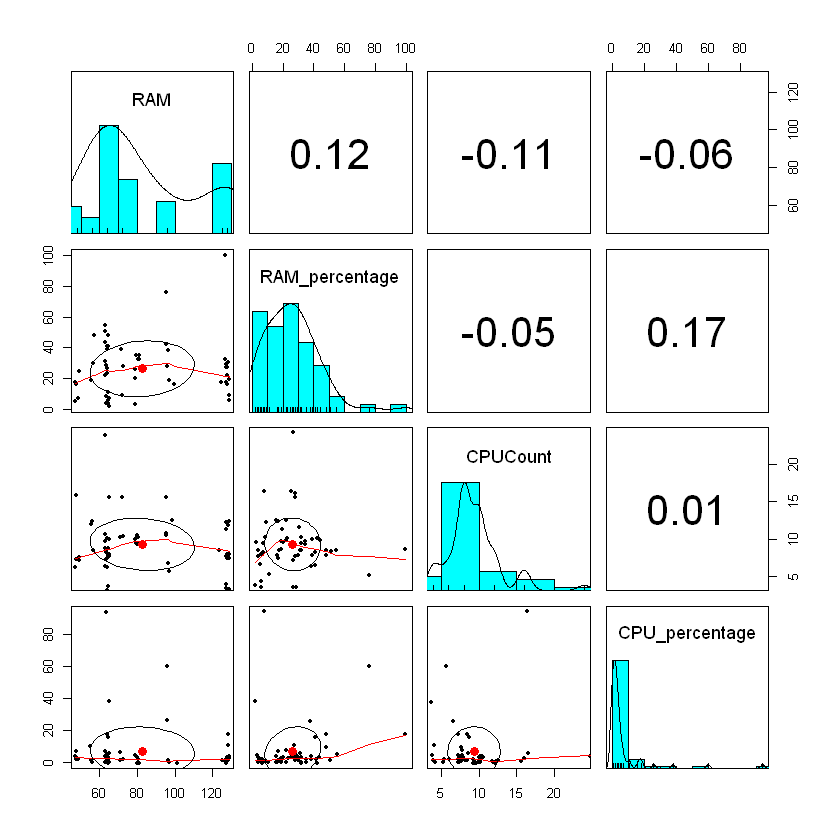

In [67]:
pairs.panels(subset(datos_agrupados, grupo == gp, select = RAM:CPU_percentage), rug = T, jiggle = T,ellipses = T)

## Grupo 3

In [68]:
gp <- "G3"

In [69]:
print(gp)
datos_grupo <- subset(datos_agrupados, grupo == gp )
print(summary(datos_grupo))
tabla <- table(datos_grupo$cpu_consumo,datos_grupo$ram_consumo)
print(tabla)

[1] "G3"
      RAM        RAM_percentage      CPUCount      CPU_percentage   grupo   
 Min.   : 1.00   Min.   :  9.00   Min.   : 1.000   Min.   : 69.00   G1:  0  
 1st Qu.: 4.00   1st Qu.: 97.00   1st Qu.: 2.000   1st Qu.: 83.00   G2:  0  
 Median : 8.00   Median :100.00   Median : 4.000   Median :100.00   G3:123  
 Mean   :15.82   Mean   : 94.09   Mean   : 3.902   Mean   : 98.36   G4:  0  
 3rd Qu.:16.00   3rd Qu.:100.00   3rd Qu.: 4.000   3rd Qu.:113.00   G5:  0  
 Max.   :96.00   Max.   :100.00   Max.   :16.000   Max.   :144.00   G6:  0  
                                                                    G7:  0  
   ram_consumo    cpu_consumo ram_aprov  cpu_aprov  
 Muy Bajo:  0   Muy Bajo: 0   Baja :77   Baja :106  
 Bajo    :  1   Bajo    : 0   Media:28   Media: 17  
 Medio   :  9   Medio   :11   Alta :18   Alta :  0  
 Alto    : 11   Alto    :41                         
 Muy Alto:102   Muy Alto:71                         
                                                    
    

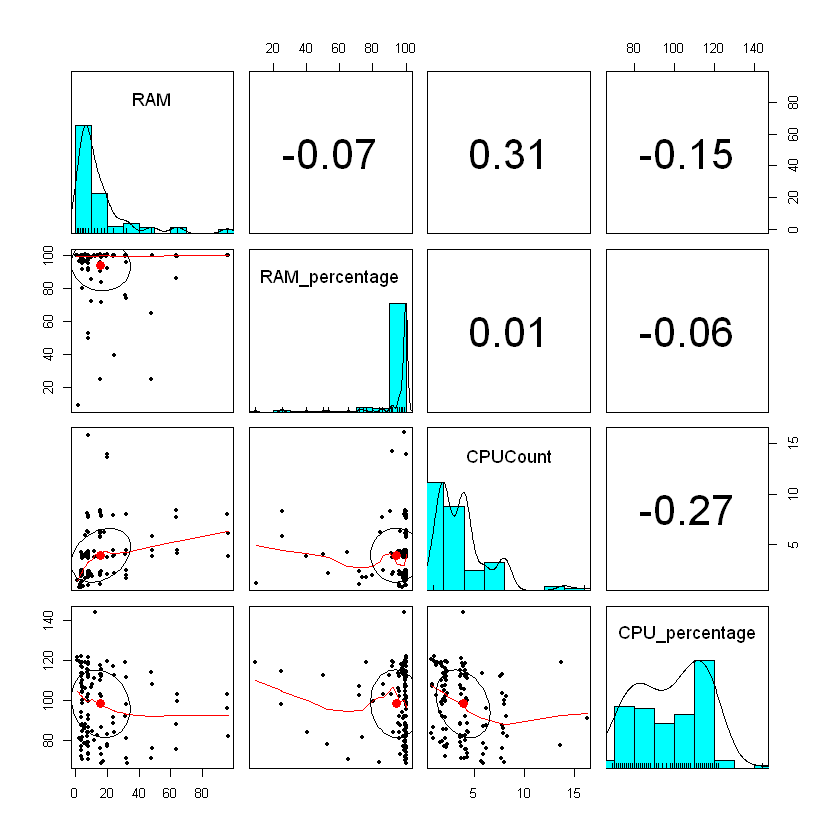

In [70]:
pairs.panels(subset(datos_agrupados, grupo == gp, select = RAM:CPU_percentage), rug = T, jiggle = T,ellipses = T)

## Grupo 4

In [71]:
gp <- "G4"

In [72]:
print(gp)
datos_grupo <- subset(datos_agrupados, grupo == gp )
print(summary(datos_grupo))
tabla <- table(datos_grupo$cpu_consumo,datos_grupo$ram_consumo )
print(tabla)

[1] "G4"
      RAM         RAM_percentage     CPUCount     CPU_percentage   grupo  
 Min.   : 48.00   Min.   : 14.0   Min.   :12.00   Min.   :  0.00   G1: 0  
 1st Qu.: 64.00   1st Qu.: 99.0   1st Qu.:24.00   1st Qu.:  9.00   G2: 0  
 Median : 92.00   Median :100.0   Median :28.00   Median : 21.00   G3: 0  
 Mean   : 93.14   Mean   : 92.8   Mean   :28.53   Mean   : 24.14   G4:49  
 3rd Qu.:128.00   3rd Qu.:100.0   3rd Qu.:32.00   3rd Qu.: 30.00   G5: 0  
 Max.   :128.00   Max.   :100.0   Max.   :64.00   Max.   :120.00   G6: 0  
                                                                   G7: 0  
   ram_consumo   cpu_consumo ram_aprov  cpu_aprov 
 Muy Bajo: 0   Muy Bajo: 9   Baja : 0   Baja : 0  
 Bajo    : 1   Bajo    :21   Media: 0   Media: 9  
 Medio   : 4   Medio   :17   Alta :49   Alta :40  
 Alto    : 2   Alto    : 1                        
 Muy Alto:42   Muy Alto: 1                        
                                                  
                                  

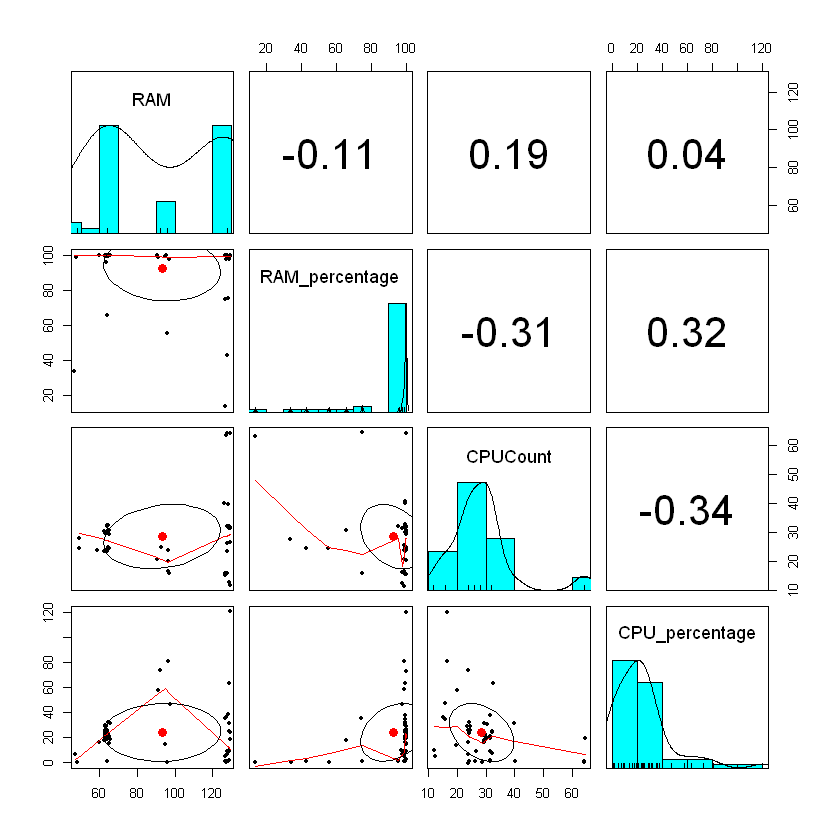

In [73]:
pairs.panels(subset(datos_agrupados, grupo == gp, select = RAM:CPU_percentage), rug = T, jiggle = T,ellipses = T)

## Grupo 5

In [74]:
gp <- "G5"

In [75]:
print(gp)
datos_grupo <- subset(datos_agrupados, grupo == gp )
print(summary(datos_grupo))
tabla <- table(datos_grupo$cpu_consumo,datos_grupo$ram_consumo )
print(tabla)

[1] "G5"
      RAM        RAM_percentage      CPUCount      CPU_percentage grupo   
 Min.   : 1.00   Min.   : 55.00   Min.   : 1.000   Min.   :22.0   G1:  0  
 1st Qu.: 6.00   1st Qu.: 98.00   1st Qu.: 2.000   1st Qu.:31.0   G2:  0  
 Median : 8.00   Median :100.00   Median : 4.000   Median :39.0   G3:  0  
 Mean   :11.61   Mean   : 97.57   Mean   : 3.722   Mean   :40.9   G4:  0  
 3rd Qu.:16.00   3rd Qu.:100.00   3rd Qu.: 4.000   3rd Qu.:48.0   G5:273  
 Max.   :40.00   Max.   :106.00   Max.   :12.000   Max.   :69.0   G6:  0  
                                                                  G7:  0  
   ram_consumo    cpu_consumo  ram_aprov   cpu_aprov  
 Muy Bajo:  0   Muy Bajo:  0   Baja :184   Baja :254  
 Bajo    :  0   Bajo    :  8   Media: 72   Media: 19  
 Medio   :  7   Medio   :265   Alta : 17   Alta :  0  
 Alto    : 21   Alto    :  0                          
 Muy Alto:245   Muy Alto:  0                          
                                                      
      

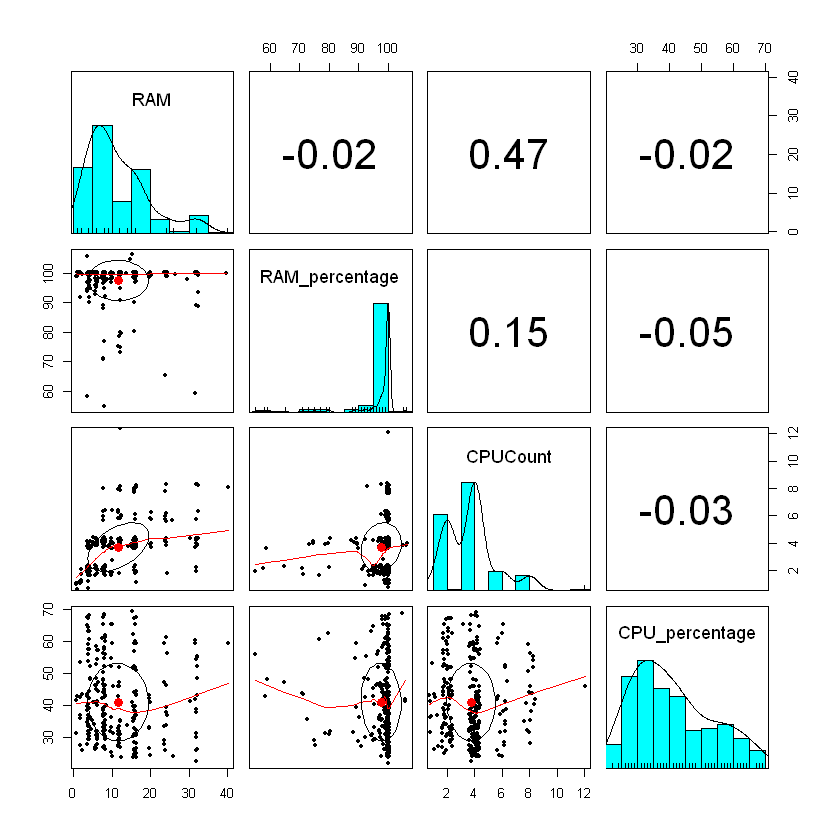

In [76]:
pairs.panels(subset(datos_agrupados, grupo == gp, select = RAM:CPU_percentage), rug = T, jiggle = T,ellipses = T)

## Grupo 6

In [77]:
gp <- "G6"

In [78]:
print(gp)
datos_grupo <- subset(datos_agrupados, grupo == gp )
print(summary(datos_grupo))
tabla <- table(datos_grupo$cpu_consumo,datos_grupo$ram_consumo )
print(tabla)

[1] "G6"
      RAM         RAM_percentage      CPUCount      CPU_percentage   grupo   
 Min.   : 1.000   Min.   : 68.00   Min.   : 1.000   Min.   : 0.000   G1:  0  
 1st Qu.: 4.000   1st Qu.: 98.00   1st Qu.: 2.000   1st Qu.: 2.000   G2:  0  
 Median : 8.000   Median :100.00   Median : 4.000   Median : 5.000   G3:  0  
 Mean   : 8.141   Mean   : 97.26   Mean   : 3.731   Mean   : 6.917   G4:  0  
 3rd Qu.: 8.000   3rd Qu.:100.00   3rd Qu.: 4.000   3rd Qu.:10.000   G5:  0  
 Max.   :32.000   Max.   :100.00   Max.   :10.000   Max.   :24.000   G6:878  
                                                                     G7:  0  
   ram_consumo    cpu_consumo  ram_aprov   cpu_aprov  
 Muy Bajo:  0   Muy Bajo:401   Baja :733   Baja :774  
 Bajo    :  0   Bajo    :477   Media:133   Media:104  
 Medio   : 18   Medio   :  0   Alta : 12   Alta :  0  
 Alto    :113   Alto    :  0                          
 Muy Alto:747   Muy Alto:  0                          
                                     

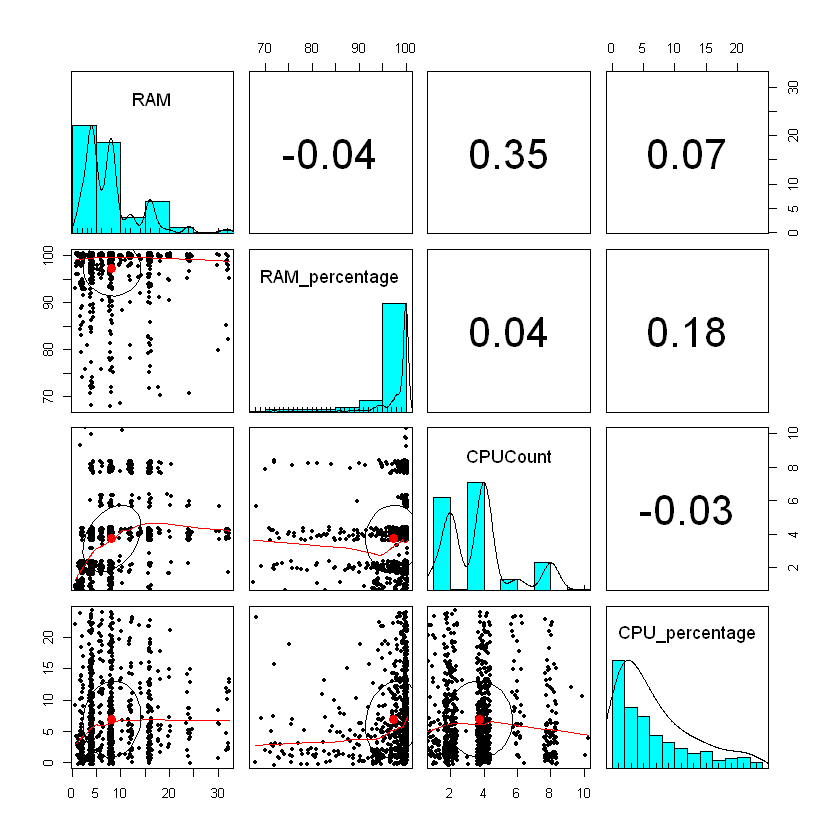

In [79]:
pairs.panels(subset(datos_agrupados, grupo == gp, select = RAM:CPU_percentage), rug = T, jiggle = T,ellipses = T)

## Grupo 7

In [80]:
gp <- "G7"

In [81]:
print(gp)
datos_grupo <- subset(datos_agrupados, grupo == gp )
print(summary(datos_grupo))
tabla <- table(datos_grupo$cpu_consumo,datos_grupo$ram_consumo )
print(tabla)

[1] "G7"
      RAM        RAM_percentage     CPUCount      CPU_percentage   grupo   
 Min.   : 1.00   Min.   : 0.00   Min.   : 1.000   Min.   : 0.000   G1:  0  
 1st Qu.: 4.00   1st Qu.:22.00   1st Qu.: 2.000   1st Qu.: 0.000   G2:  0  
 Median : 8.00   Median :39.00   Median : 4.000   Median : 1.000   G3:  0  
 Mean   :13.69   Mean   :37.36   Mean   : 4.493   Mean   : 5.567   G4:  0  
 3rd Qu.:16.00   3rd Qu.:52.00   3rd Qu.: 6.000   3rd Qu.: 6.000   G5:  0  
 Max.   :48.00   Max.   :68.00   Max.   :16.000   Max.   :63.000   G6:  0  
                                                                   G7:217  
   ram_consumo    cpu_consumo  ram_aprov   cpu_aprov  
 Muy Bajo:  3   Muy Bajo:153   Baja :137   Baja :171  
 Bajo    : 57   Bajo    : 52   Media: 40   Media: 46  
 Medio   :157   Medio   : 12   Alta : 40   Alta :  0  
 Alto    :  0   Alto    :  0                          
 Muy Alto:  0   Muy Alto:  0                          
                                                     

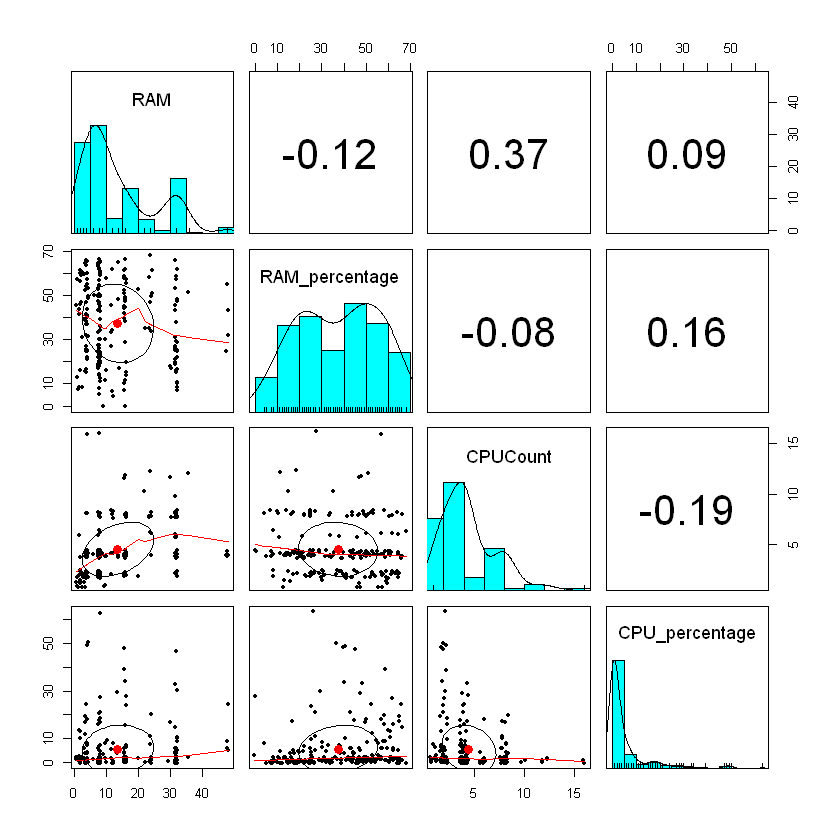

In [82]:
pairs.panels(subset(datos_agrupados, grupo == gp, select = RAM:CPU_percentage), rug = T, jiggle = T,ellipses = T)